# This a jupyter notebook guide on domain interaction anaylsis for chr2, in the regime of A,B compartments

by Pu Zheng 

2020.06.06


## Import packages

In [1]:
# imports
import sys, os, glob, time, copy
import numpy as np
import scipy
import pickle

sys.path.append(os.path.abspath(r"..\."))

import source as ia

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist,pdist,squareform

print(os.getpid()) # print this so u can terminate through cmd / task-manager

45452


## Import plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
parent_figure_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure'
figure_folder = os.path.join(parent_figure_folder, 'Figure3')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure\Figure3


# 0. Load data

In [5]:
## chr2 dataset
# load data containing candidates
data_folder = r'\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\Repicked_chromosome_data'

data_rep1 = pickle.load(open(os.path.join(data_folder, r'chr2_after_selection.pkl'), 'rb'))

In [22]:
data_rep2 = pickle.load(open(os.path.join(data_folder, r'chr2_repeat_after_selection.pkl'), 'rb'))

In [23]:
data_rep2.keys()

dict_keys(['fov_ids', 'cell_ids', 'chrom_ids', 'dna_chrom_coords', 'raw_chrom_coords', 'relabeled_inds', 'params', 'dna_zxys'])

## genomic coordinate info

In [6]:
# reference folder
ref_folder = r'\\10.245.74.69\Chromatin_NAS_3\20191007_CTP07_chr2\Analysis'
# load genomic positions
genomic_dic = ia.get_img_info.Load_Region_Positions(ref_folder)
mid_positions = np.array([_v['midpoint'] for _k,_v in genomic_dic.items()])

genomic_distance_map = squareform(pdist(mid_positions[:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

genomic_positions_Mb = np.round(mid_positions/1e6, 2)
# genomic dist map
genomic_dist_mat = squareform(pdist(genomic_positions_Mb[:,np.newaxis]))

region_starts = np.array([_v['start'] for _k,_v in genomic_dic.items()], dtype=np.int)
region_ends = np.array([_v['end'] for _k,_v in genomic_dic.items()], dtype=np.int)

- Importing csv file: \\10.245.74.69\Chromatin_NAS_3\20191007_CTP07_chr2\Analysis\Region_Positions.csv
- header: ['region', 'chr', 'start', 'end', 'midpoint']
-- 935 genomic regions loaded!


In [90]:
from source.figure_tools.distmap import plot_distance_map
print(figure_folder)

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\cleaned_repeat_figure\Figure3


In [98]:
from matplotlib.colors import LogNorm

contact_limits = [0.02, 0.8]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

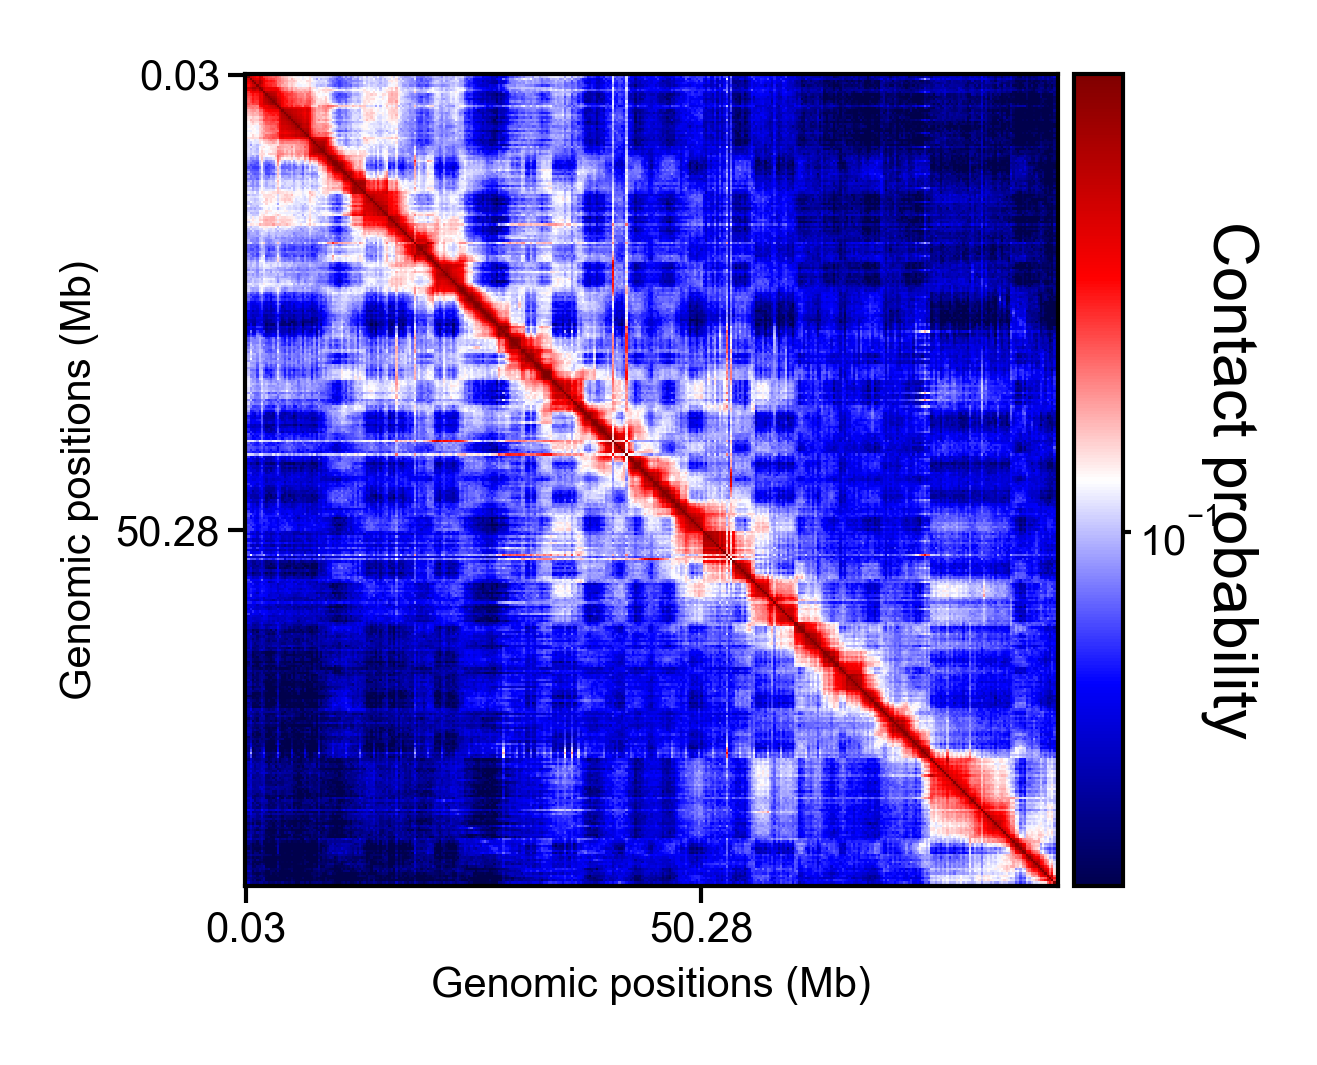

In [99]:

distmap_ax = plot_distance_map(p_contact_rep1_map, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                               tick_labels=genomic_positions_Mb[:357], 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Contact probability',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'FigS1B2_contact_map.pdf',
                               font_size=5)

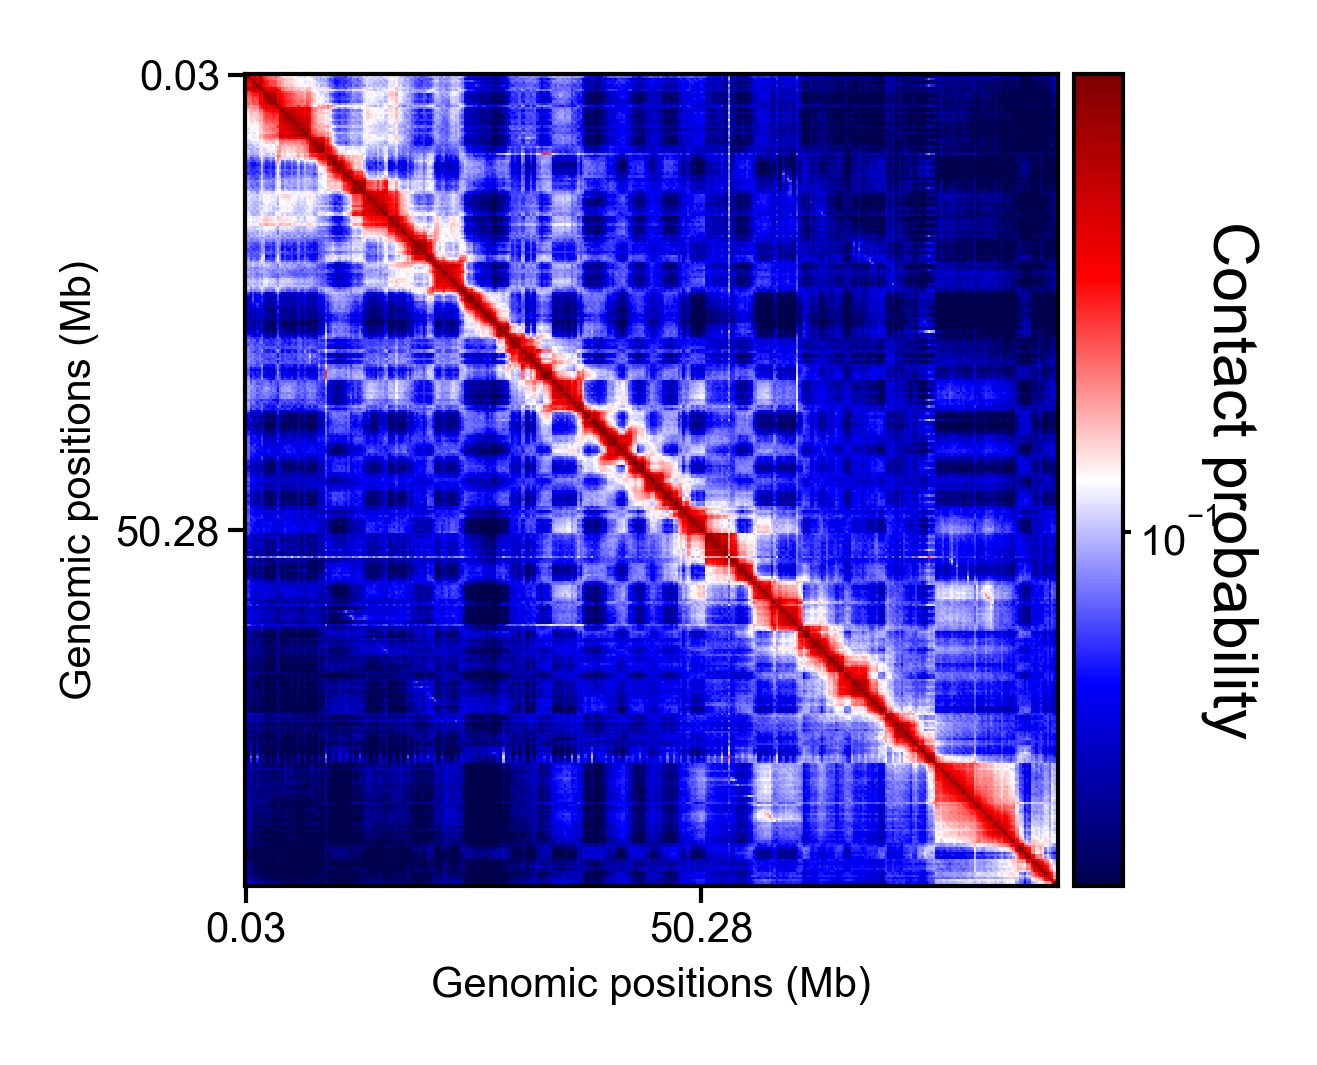

In [100]:
distmap_ax = plot_distance_map(p_contact_rep2_map, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                               tick_labels=genomic_positions_Mb[:357], 
                               ax_label='Genomic positions (Mb)', 
                               colorbar_labels='Contact probability',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'FigS1B2_contact_map.pdf',
                               font_size=5)

## 0.1 prepare data domains and compartments

Note: Please check what parameter you have used to call domains for chr2 and run it here

### 0.1.1 domains

In [7]:
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.85 
domain_dist_cutoff = 1000 # nm

_domain_args = [(_hzxys[:,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep1['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 66.178s.


### 0.1.2: domain interaction calling

In [9]:
# cutoff for:
#  domain pairs touching each other -> insulation score <= 2
#  domain pairs fully intermix with each other -> insulation score <= 1
domain_interact_cutoff = 2
domain_intermix_cutoff = 1
#
cutoffs = [domain_intermix_cutoff,domain_interact_cutoff]

fuses_all_v2 = [[] for cutoff in cutoffs]
for _hzxys, _domain_starts in zip(data_rep1['dna_hzxys'], data_rep1['domain_starts']):
    zxy = _hzxys[:,1:]
    dom_starts_f = _domain_starts

    bad = np.isnan(zxy[:,0])
    zxy_ = zxy[~bad]
    mat=squareform(pdist(zxy_))
    dom_starts = np.zeros(len(zxy))
    dom_starts[dom_starts_f[:-1]]=1
    dom_starts = list(np.where(dom_starts[~bad])[0])+[len(zxy_)]
    fuses_all_v2_=[[] for cutoff in cutoffs]
    for i in range(len(dom_starts)-1):
        for j in range(i):
            in_i = squareform(mat[dom_starts[i]:dom_starts[i+1],dom_starts[i]:dom_starts[i+1]])
            in_j = squareform(mat[dom_starts[j]:dom_starts[j+1],dom_starts[j]:dom_starts[j+1]])
            in_doms = np.median(np.concatenate([in_i,in_j]))
            out_doms = np.median(mat[dom_starts[i]:dom_starts[i+1],dom_starts[j]:dom_starts[j+1]])
            ins_score = out_doms/in_doms
            for icutoff,cutoff in enumerate(cutoffs):
                if ins_score<cutoff:
                    fuses_all_v2_[icutoff].append([i,j])
    for icutoff,cutoff in enumerate(cutoffs):
        fuses_all_v2[icutoff].append(fuses_all_v2_[icutoff])


#save_fl  = 'dom_fuses_chr21_newAnalysis___'+str(int(cutoff_cor*100))+'__cutoff'+str(cutoffs)+'.npy'
#print(os.path.abspath(save_fl))
#np.save(save_fl,fuses_all_v2)

### 0.2 Compartment calling

In [76]:
# Do PCA
from sklearn.decomposition import PCA

In [40]:
# load Hi-C
# load Hi-C
hic_map = np.load(r'Z:\Hi-C\chr2_hg38_50000.npy')
region_ids = pickle.load(open(os.path.join(r'\\10.245.74.158\Chromatin_NAS_4\201911_chr2_processed_data', 
                                           'kept_reg_ids_250kb.pkl'), 'rb'))

region_indices = np.array(region_ids,dtype=np.int)
hic_map = hic_map[region_indices][:,region_indices]
hic_map[np.isnan(hic_map)] = 0

In [242]:
# Hi-C
gaussian_sigma = 1.5
# p arm
p_crop = slice(0,357)
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_hic_map = hic_map[p_crop, p_crop]
# normalize genomic distance effects
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
hic_entries = p_hic_map[np.triu_indices(len(p_hic_map),1)]
p_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
p_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_kept]), 
                              np.log(hic_entries[p_kept]))
print(p_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_lr.slope + p_lr.intercept)
#for _i in range(len(p_normalization_mat)):
#    p_normalization_mat[_i,_i] = 1
p_normed_hic_map = p_hic_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_hic_corr_map = np.corrcoef(gaussian_filter(p_normed_hic_map, gaussian_sigma))
# PCA
p_hic_model = PCA(1)
p_hic_model.fit(p_hic_corr_map)
p_hic_pc1 = np.reshape(p_hic_model.fit_transform(p_hic_corr_map), -1)

# q arm
q_crop = slice(357, len(contact_rep1_map))
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_hic_map = hic_map[q_crop, q_crop]
# normalize genomic distance effects
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
hic_entries = q_hic_map[np.triu_indices(len(q_hic_map),1)]
q_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
q_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_kept]), 
                              np.log(hic_entries[q_kept]))
print(q_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_lr.slope + q_lr.intercept)
#for _i in range(len(q_normalization_mat)):
#    q_normalization_mat[_i,_i] = 1
q_normed_hic_map = q_hic_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_hic_corr_map = np.corrcoef(gaussian_filter(q_normed_hic_map, gaussian_sigma))
# PCA
q_hic_model = PCA(1)
q_hic_model.fit(q_hic_corr_map)
q_hic_pc1 = np.reshape(q_hic_model.fit_transform(q_hic_corr_map), -1)

LinregressResult(slope=-0.722803338678619, intercept=13.360714131321757, rvalue=-0.7250408584341543, pvalue=0.0, stderr=0.0030186725566035957)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


LinregressResult(slope=-0.7451356470768307, intercept=13.73025351238045, rvalue=-0.7769559406456998, pvalue=0.0, stderr=0.0018034121285637678)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [30]:
zxys_rep1_list = np.array(data_rep1['dna_hzxys'])[:,:,1:4]
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])
# calculate contact freq map
contact_th = 500
contact_rep1_map = np.nanmean(distmap_rep1_list<contact_th, axis=0)

In [243]:
gaussian_sigma = 1.5
# p arm
p_crop = slice(0,357)
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_contact_rep1_map = contact_rep1_map[p_crop, p_crop]
# normalize genomic distance effect
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
contact_entries = p_contact_rep1_map[np.triu_indices(len(p_contact_rep1_map),1)]
p_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
p_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_kept]), 
                              np.log(contact_entries[p_kept]))
print(p_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_lr.slope + p_lr.intercept)
for _i in range(len(p_normalization_mat)):
    p_normalization_mat[_i,_i] = 1
p_normed_contact_rep1_map = p_contact_rep1_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_contact_corr_rep1_map = np.corrcoef(gaussian_filter(p_normed_contact_rep1_map, gaussian_sigma))
# PCA
p_contact_model_rep1 = PCA(1)
p_contact_model_rep1.fit(p_contact_corr_rep1_map)
p_contact_pc1_rep1 = np.reshape(p_contact_model_rep1.fit_transform(p_contact_corr_rep1_map), -1)

# q arm
q_crop = slice(357, len(contact_rep1_map))
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_contact_rep1_map = contact_rep1_map[q_crop, q_crop]
# normalize genomic distance effects
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
contact_entries = q_contact_rep1_map[np.triu_indices(len(q_contact_rep1_map),1)]
q_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
q_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_kept]), 
                              np.log(contact_entries[q_kept]))
print(q_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_lr.slope + q_lr.intercept)
for _i in range(len(q_normalization_mat)):
    q_normalization_mat[_i,_i] = 1
q_normed_contact_rep1_map = q_contact_rep1_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_contact_corr_rep1_map = np.corrcoef(gaussian_filter(q_normed_contact_rep1_map, gaussian_sigma))

# Do PCA
q_contact_model_rep1 = PCA(1)
q_contact_model_rep1.fit(q_contact_corr_rep1_map)
q_contact_pc1_rep1 = np.reshape(q_contact_model_rep1.fit_transform(q_contact_corr_rep1_map), -1)

# merge rep1 AB_dict
data_rep1['p_AB_dict'] = {'A':np.where(p_contact_pc1_rep1 >= 0)[0],
                         'B':np.where(p_contact_pc1_rep1 < 0)[0],}
data_rep1['q_AB_dict'] = {'A':np.where(q_contact_pc1_rep1 >= 0)[0]+357,
                         'B':np.where(q_contact_pc1_rep1 < 0)[0]+357,}
data_rep1['AB_dict'] = {'A':np.concatenate([data_rep1['p_AB_dict']['A'],data_rep1['q_AB_dict']['A']]),
                        'B':np.concatenate([data_rep1['p_AB_dict']['B'],data_rep1['q_AB_dict']['B']]),}

LinregressResult(slope=-0.5265216347352745, intercept=6.016990941534811, rvalue=-0.8618571596050613, pvalue=0.0, stderr=0.001229082465105864)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


LinregressResult(slope=-0.6411360947921406, intercept=7.782829702834636, rvalue=-0.9191891948084866, pvalue=0.0, stderr=0.0006726740986457173)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


## Fig 2D: correlation matrix for proximity frequency map

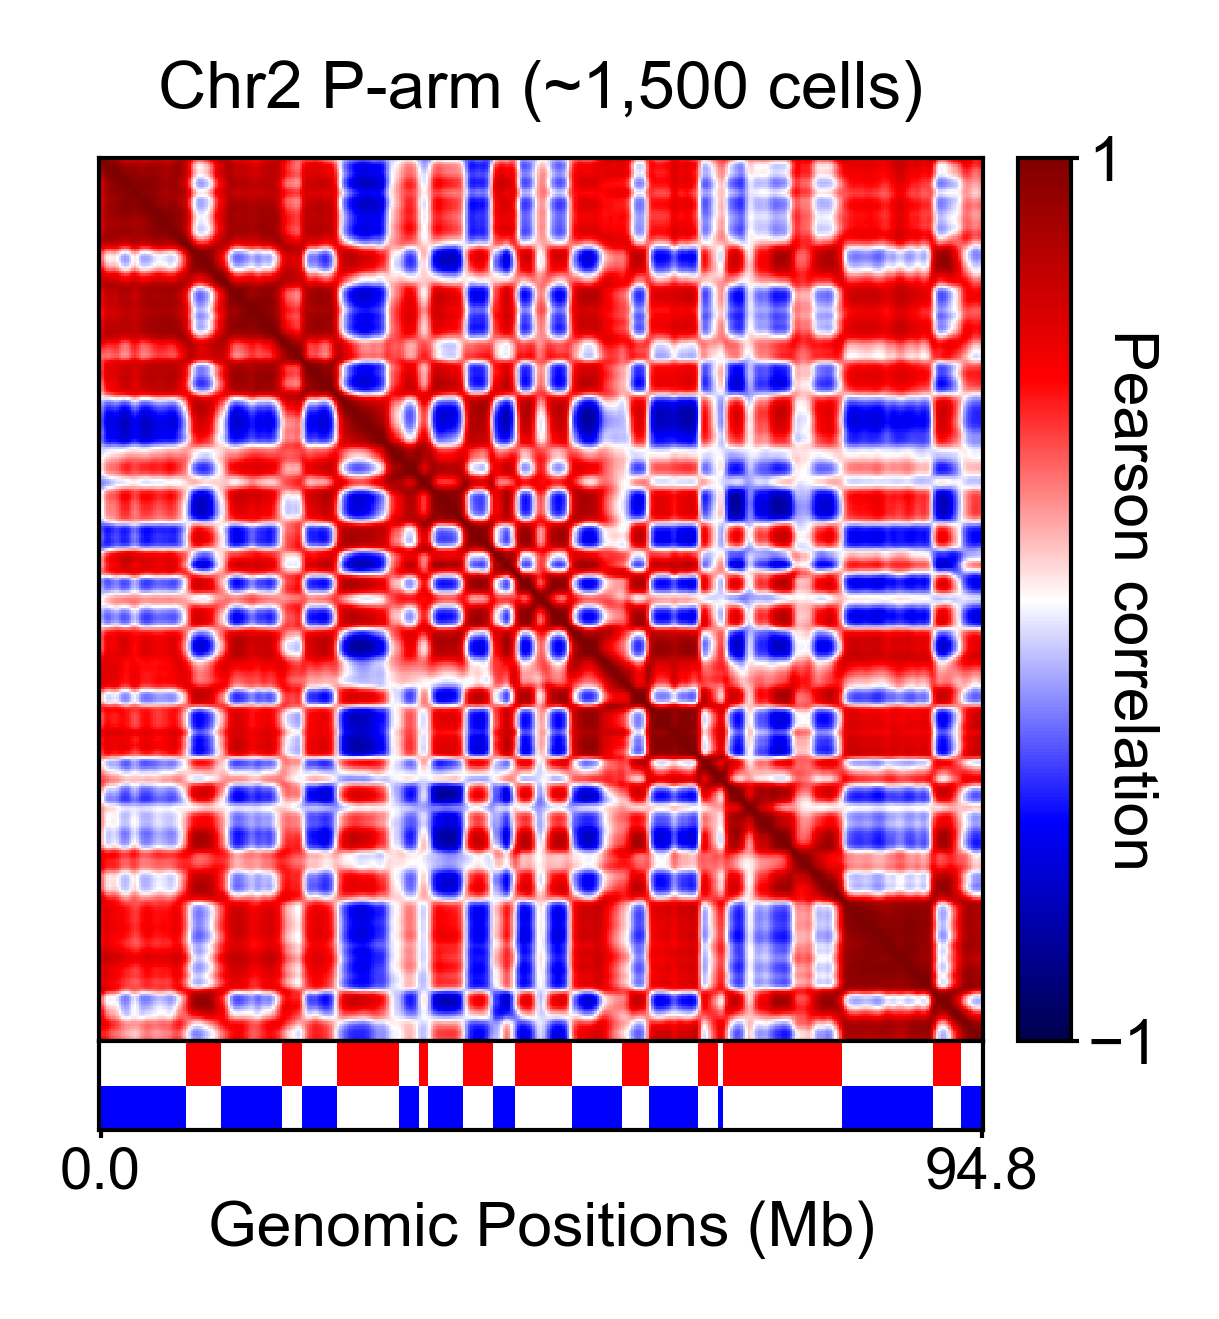

In [244]:
lims = [0,len(p_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(p_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['p_AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['p_AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(p_contact_corr_rep1_map)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(genomic_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr2 P-arm (~1,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D1_chr2_p_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

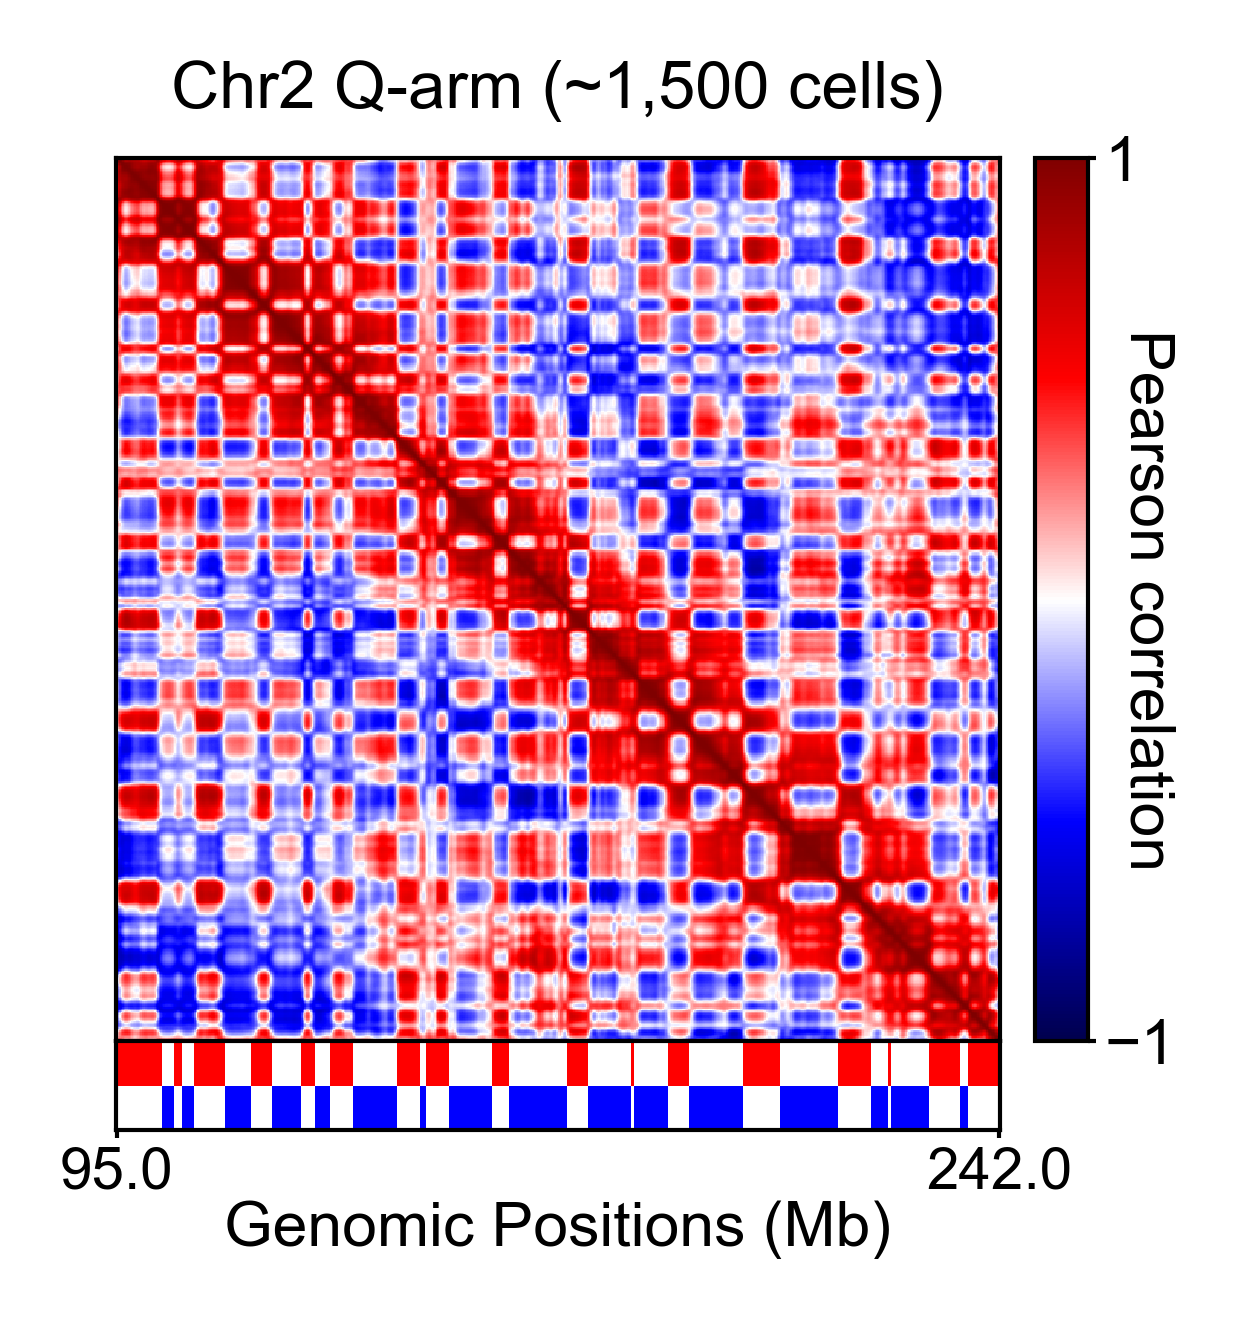

In [245]:
lims = [0,len(q_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(q_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['q_AB_dict']['A']-q_crop.start, height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['q_AB_dict']['B']-q_crop.start, height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(q_contact_corr_rep1_map)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(genomic_positions_Mb[q_crop][_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr2 Q-arm (~1,500 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D1_chr2_q_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

## Fig S2F: PC1 barplot for p and q arm

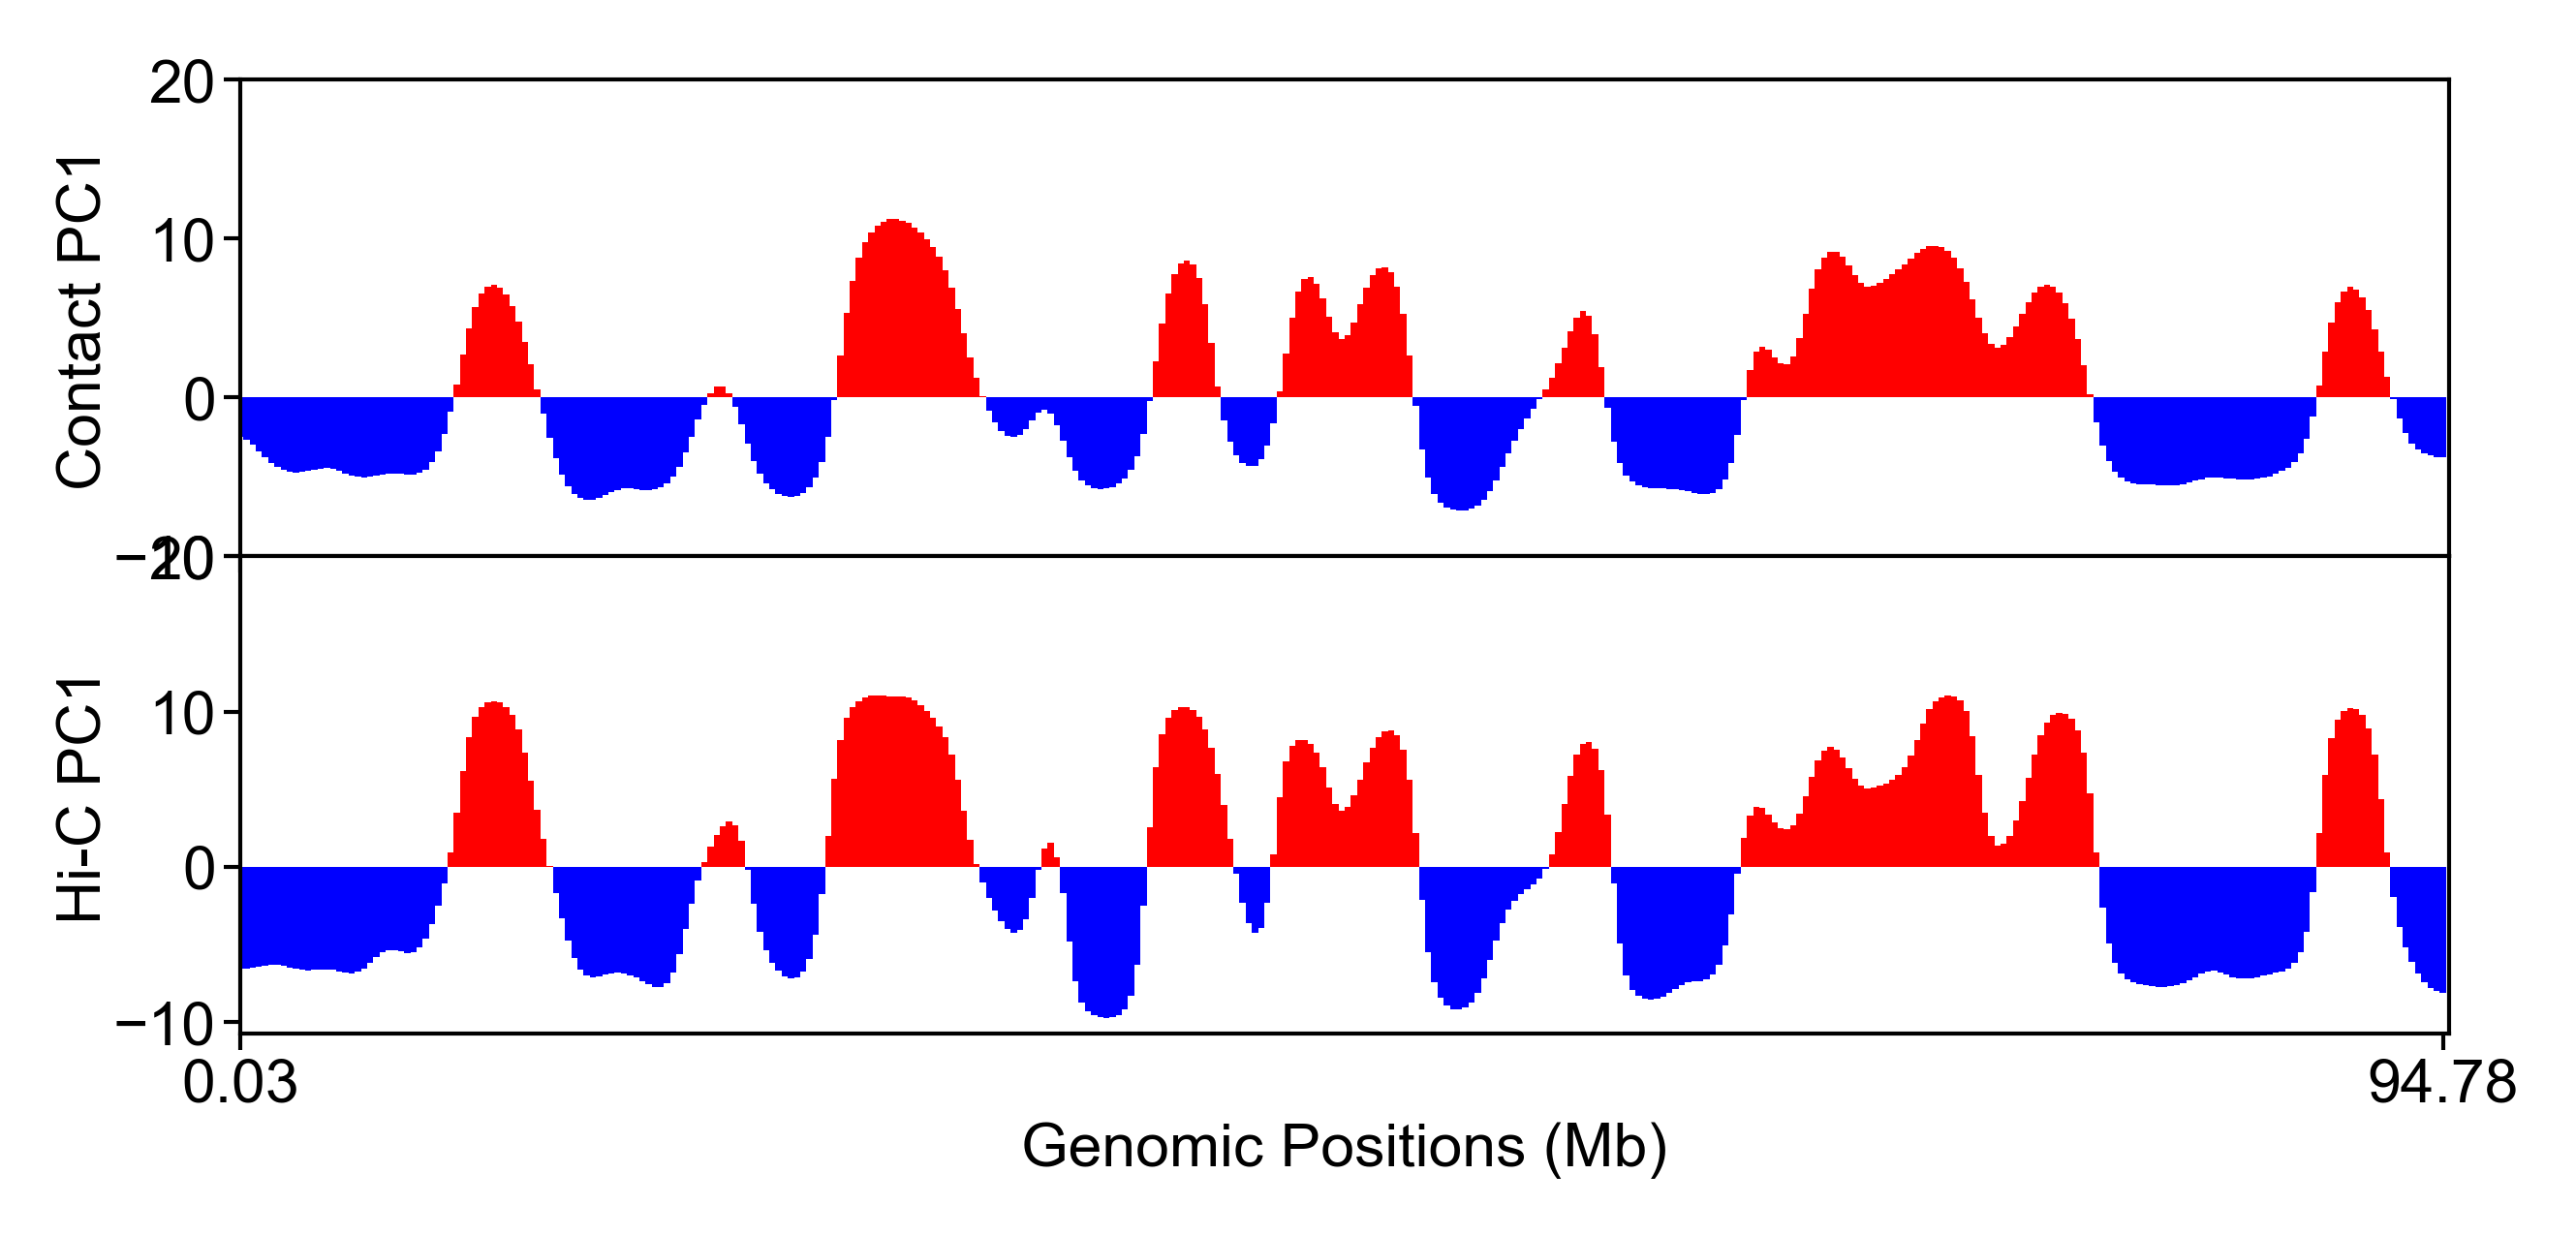

In [240]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(p_contact_pc1_rep1>=0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(p_contact_pc1_rep1<0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-10,10])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(p_hic_pc1>=0)[0],
               p_hic_pc1[p_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(p_hic_pc1<0)[0],
               p_hic_pc1[p_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
#hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(p_contact_pc1_rep1)])
_xticks = [0, len(p_contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(genomic_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_p_arm_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

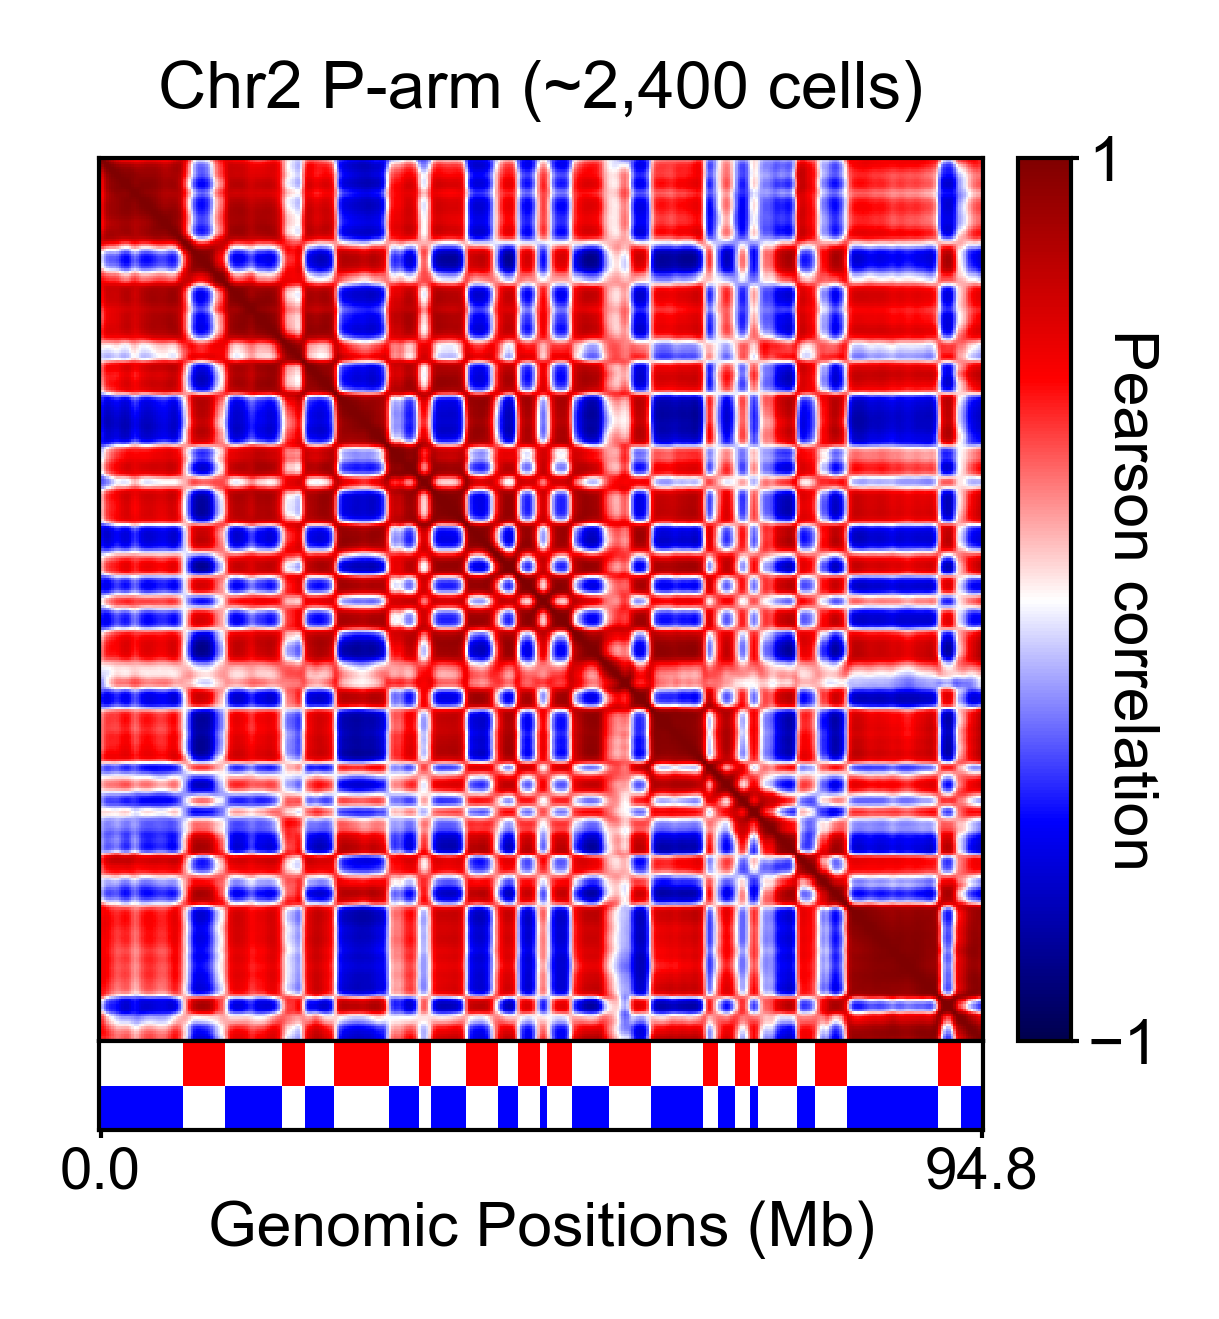

In [218]:
lims = [0,len(p_contact_corr_rep2_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(p_contact_corr_rep2_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep2['p_AB_dict']['A'], height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep2['p_AB_dict']['B'], height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])

_xticks = [0, len(p_contact_corr_rep2_map)-1]
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(np.round(genomic_positions_Mb[_xticks],1))
# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)
#left_ax.set_ylim([max(ylims)-0.5, min(ylims)-0.5])

ax1.set_title(f"Chr2 P-arm (~2,400 cells)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D1_chr2_p-arm_contact_corr_rep2.pdf'), transparent=True)

plt.show()

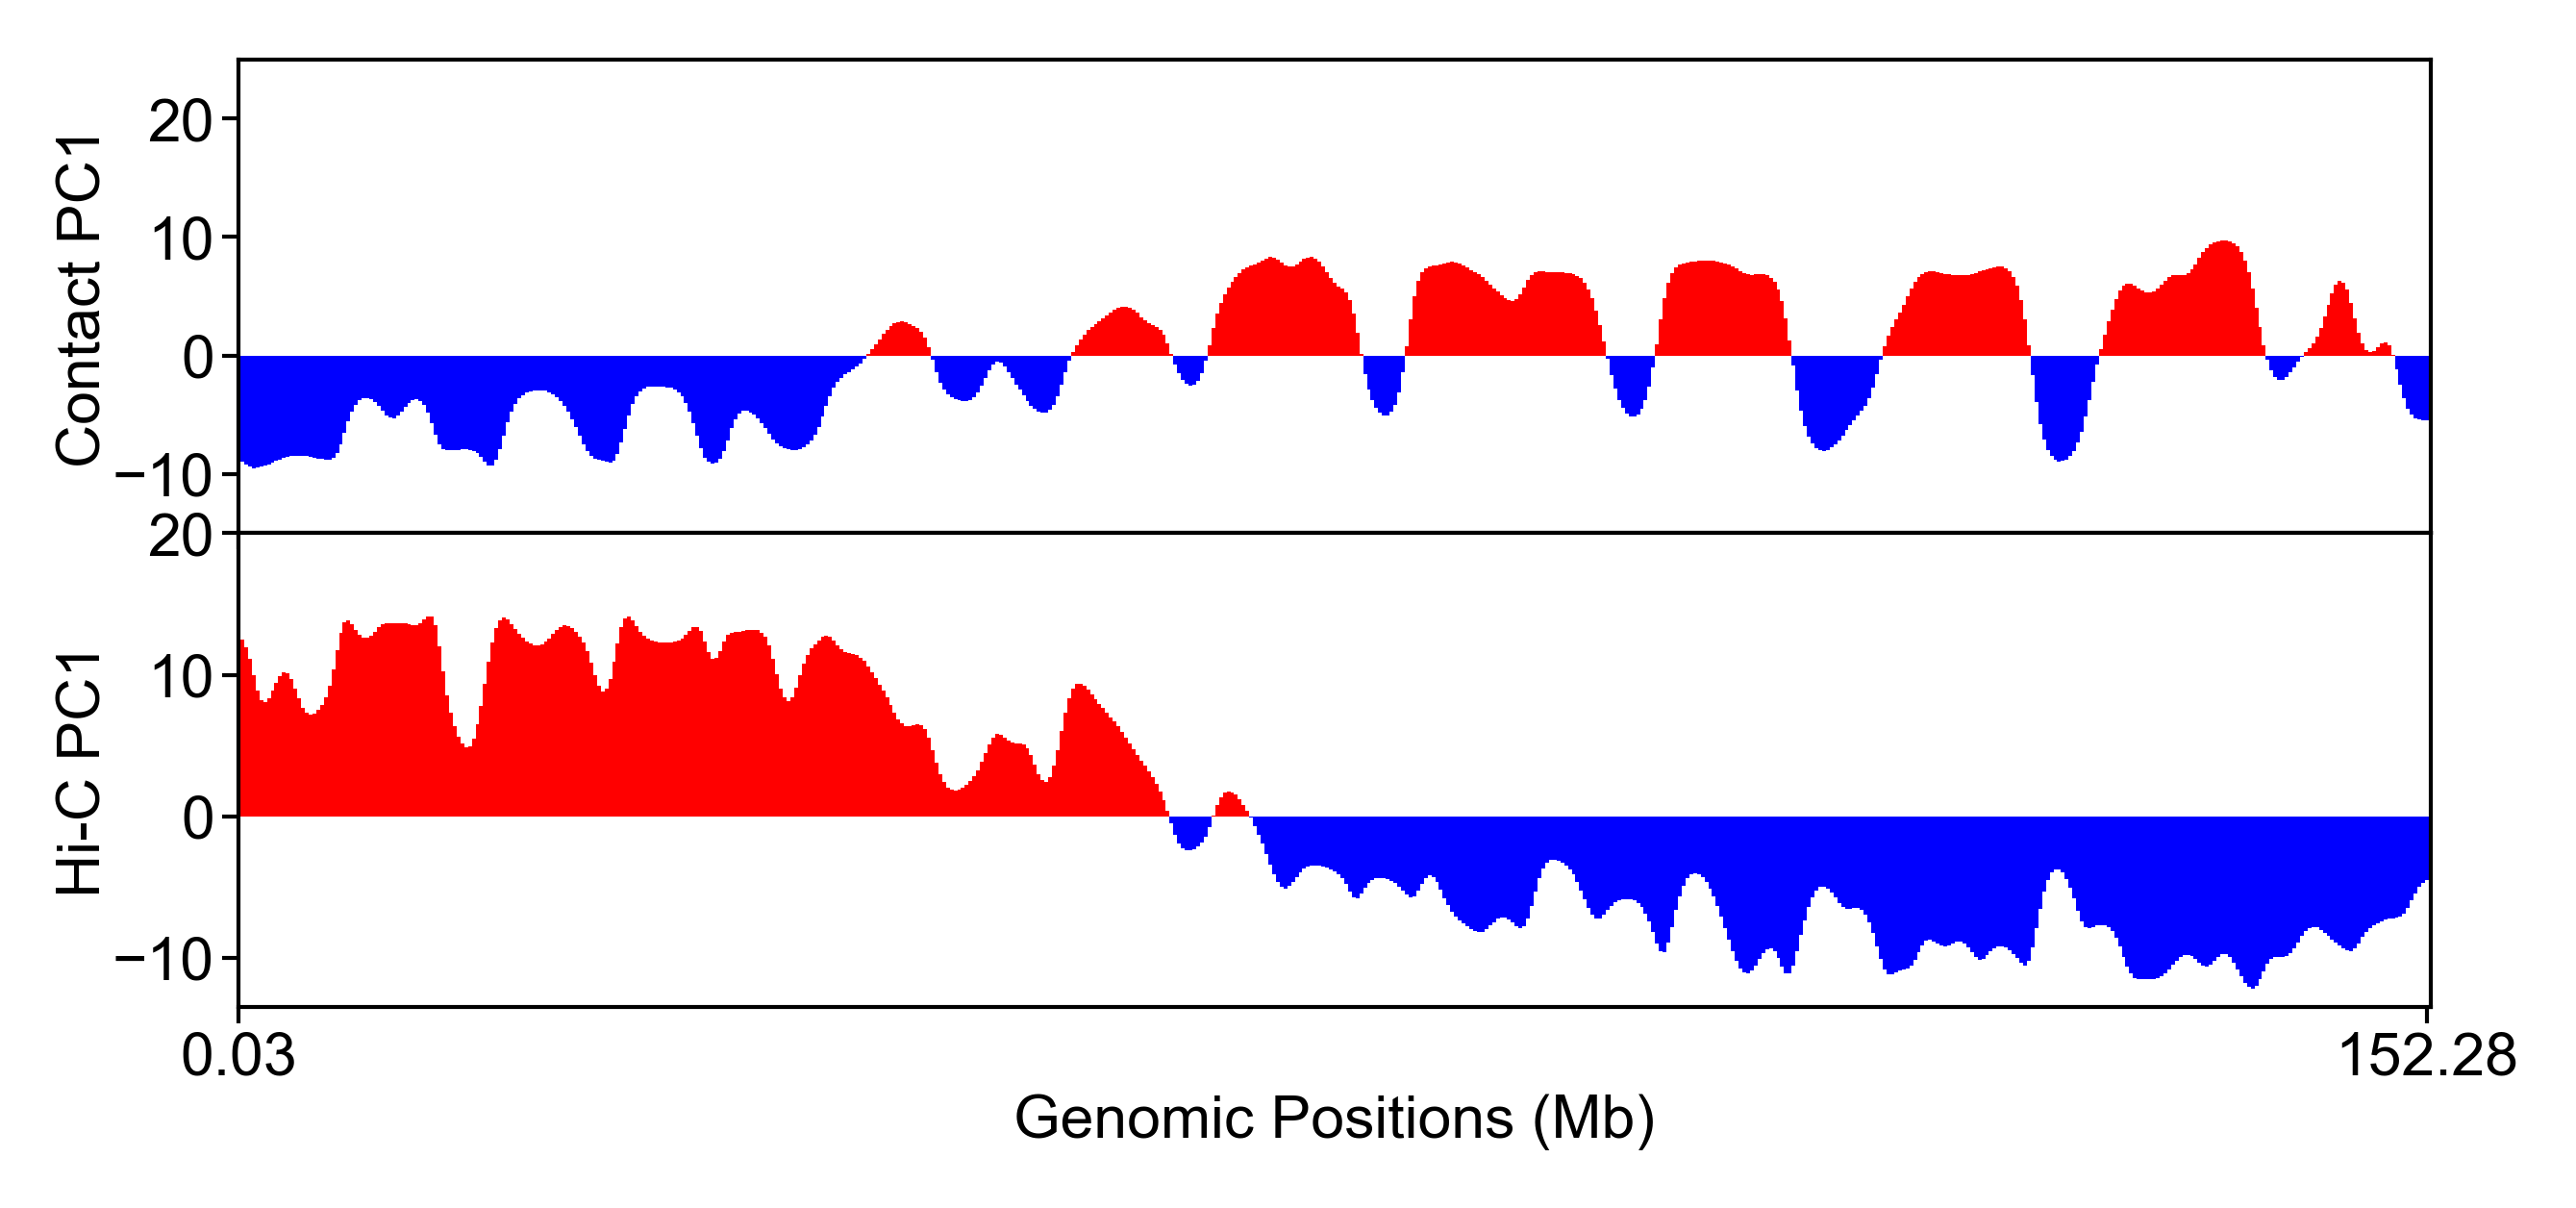

In [241]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(q_contact_pc1_rep1>=0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(q_contact_pc1_rep1<0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(q_hic_pc1>=0)[0],
               q_hic_pc1[q_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(q_hic_pc1<0)[0],
               q_hic_pc1[q_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
#hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(q_contact_pc1_rep1)])
_xticks = [0, len(q_contact_pc1_rep1)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(genomic_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_q_arm_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

In [36]:
zxys_rep2_list = np.array(data_rep2['dna_zxys'])[:,:,:]
distmap_rep2_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep2_list])
# calculate contact freq map
contact_th = 500
contact_rep2_map = np.nanmean(distmap_rep2_list<contact_th, axis=0)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [83]:
# p arm
p_crop = slice(0,357)
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_contact_rep2_map = contact_rep2_map[p_crop, p_crop]
# normalize genomic distance effects
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
contact_entries = p_contact_rep2_map[np.triu_indices(len(p_contact_rep2_map),1)]
p_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
p_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_kept]), 
                              np.log(contact_entries[p_kept]))
print(p_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_lr.slope + p_lr.intercept)
for _i in range(len(p_normalization_mat)):
    p_normalization_mat[_i,_i] = 1
p_normed_contact_rep2_map = p_contact_rep2_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_contact_corr_rep2_map = np.corrcoef(gaussian_filter(p_normed_contact_rep2_map, 1.5))
# PCA
p_contact_model_rep2 = PCA(1)
p_contact_model_rep2.fit(p_contact_corr_rep2_map)
p_contact_pc1_rep2 = np.reshape(p_contact_model_rep2.fit_transform(p_contact_corr_rep2_map), -1)

# For rep2, we only have p-arm AB_dict
data_rep2['p_AB_dict'] = {'A':np.where(p_contact_pc1_rep2 >= 0)[0],
                         'B':np.where(p_contact_pc1_rep2 < 0)[0],}

LinregressResult(slope=-0.5503456961538782, intercept=6.232869217271032, rvalue=-0.8533609505787046, pvalue=0.0, stderr=0.0013337374824070633)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


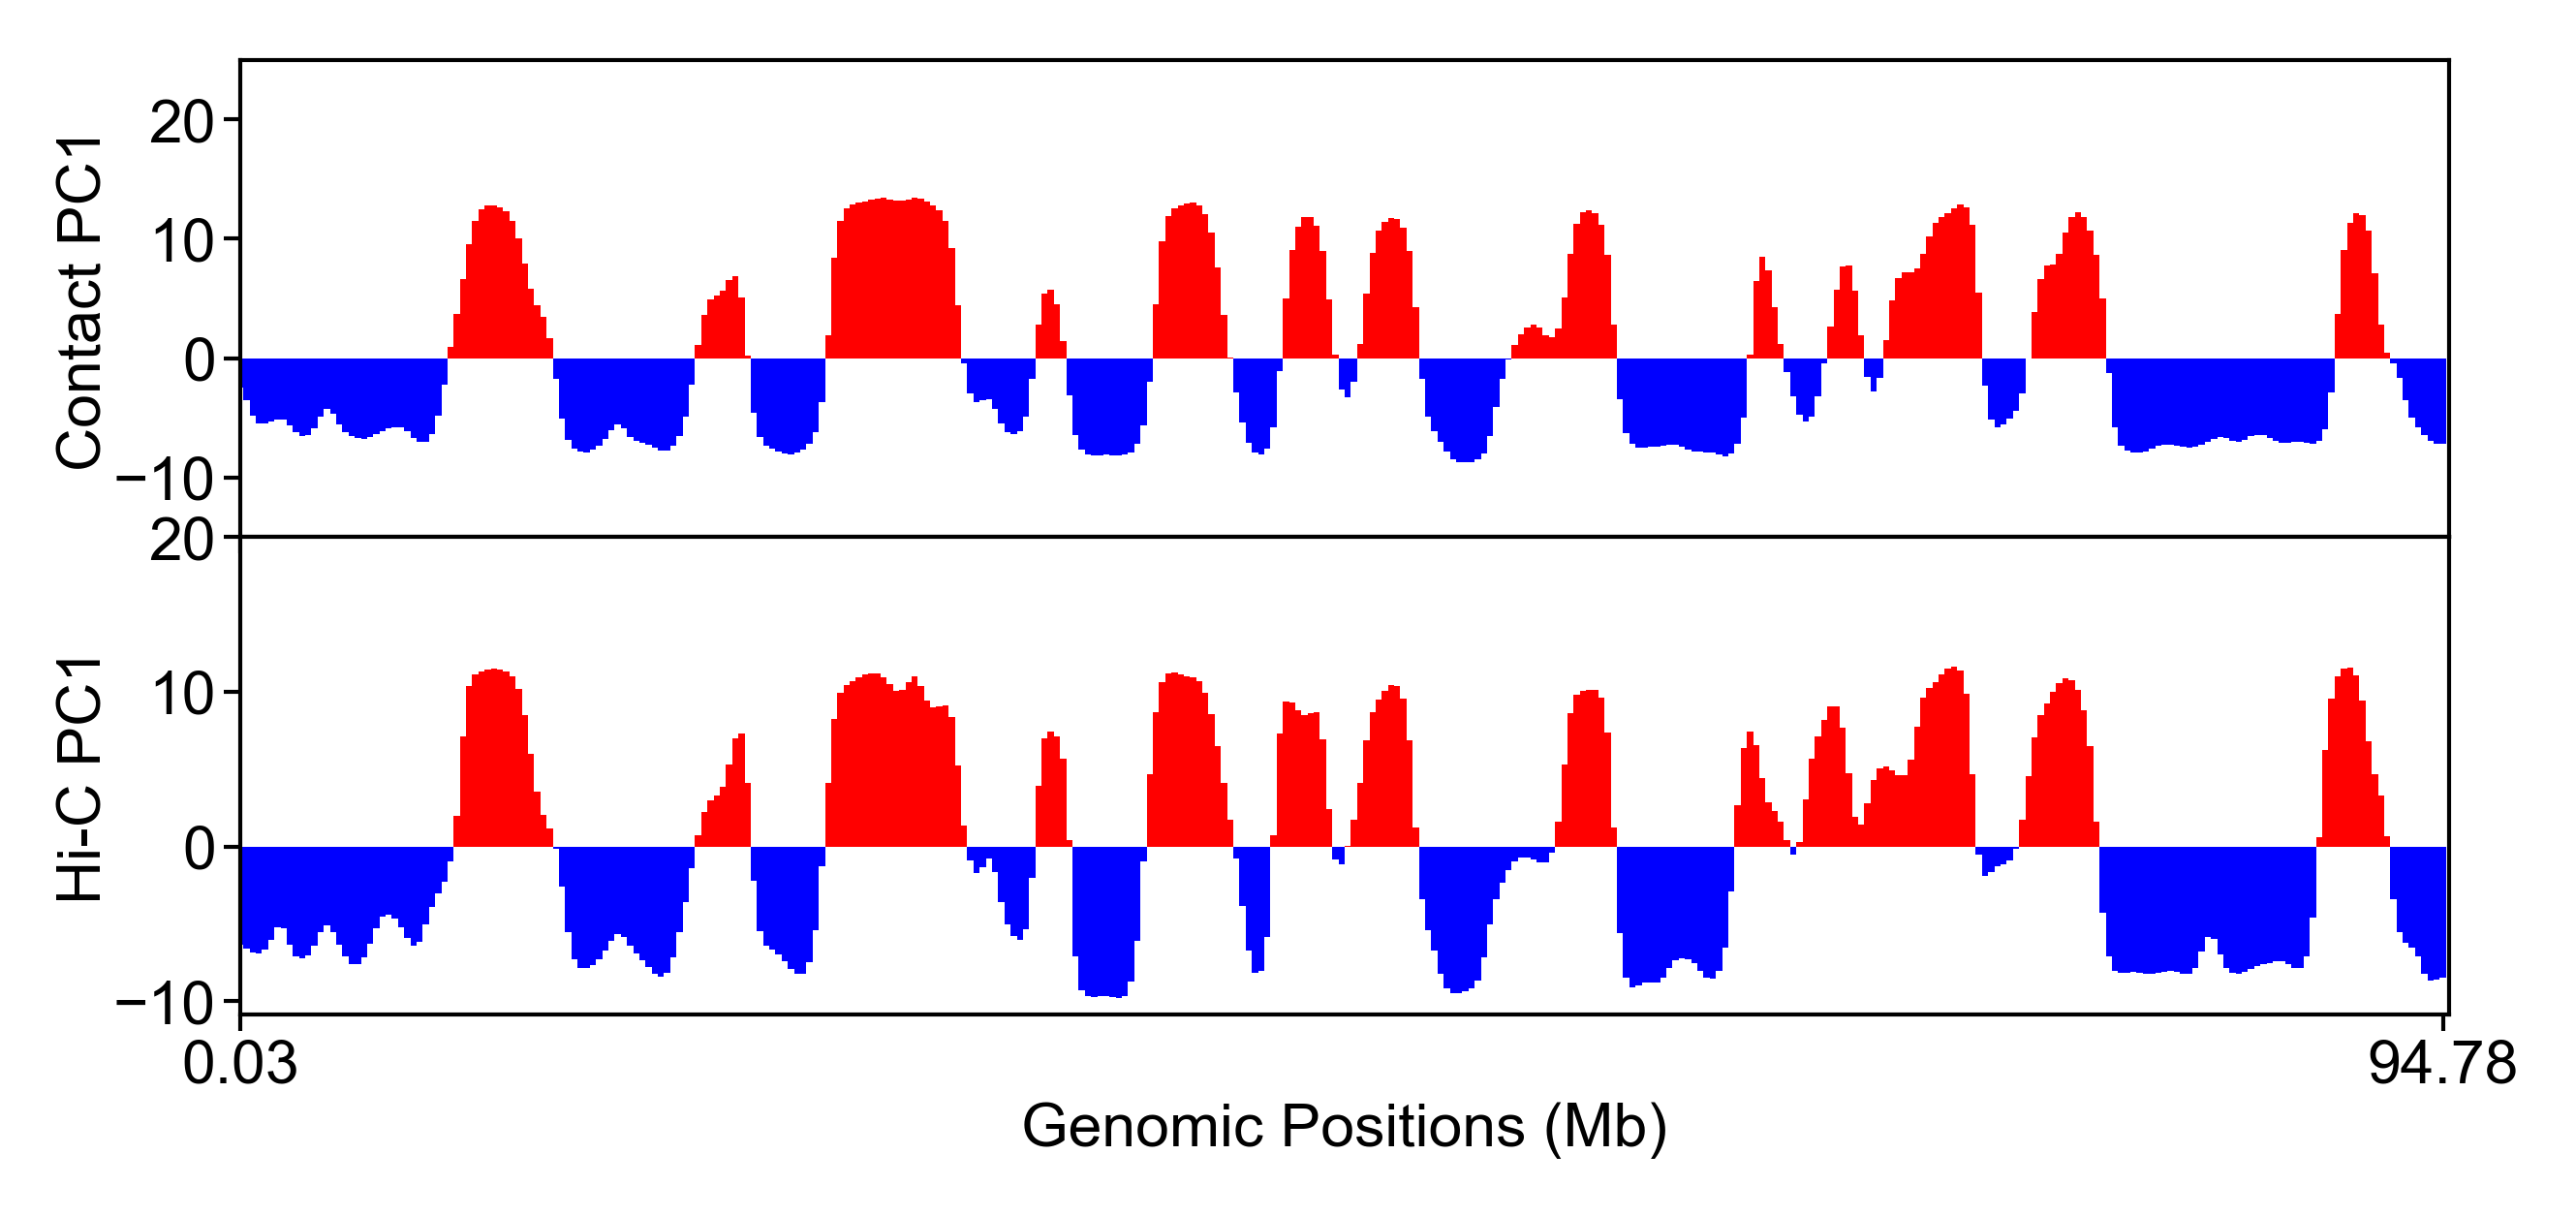

In [65]:
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(p_contact_pc1_rep2>=0)[0],
               p_contact_pc1_rep2[p_contact_pc1_rep2>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(p_contact_pc1_rep2<0)[0],
               p_contact_pc1_rep2[p_contact_pc1_rep2<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-15,25])
contact_ax.set_yticks([-10,0,10,20])
contact_ax.set_ylabel("Contact PC1", fontsize=_font_size, labelpad=0)


# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(p_hic_pc1>=0)[0],
               p_hic_pc1[p_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(p_hic_pc1<0)[0],
               p_hic_pc1[p_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
#hic_ax.set_ylim([-15,25])
hic_ax.set_yticks([-10,0,10,20])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(p_contact_pc1_rep2)])
_xticks = [0, len(p_contact_pc1_rep2)-1]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(genomic_positions_Mb[_xticks])
hic_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_p-arm_PC1_barplot_rep2.pdf'), transparent=True)

plt.show()

## 0.3 density score

In [177]:
del(data_rep1['dna_density_scores'])

In [178]:
# density for the entire chr
import multiprocessing as mp
num_threads=32
density_var = 125 # nm

_dna_density_args = [(_hzxys,_hzxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep1['dna_hzxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 34.128s.


### 0.3.1 density for only p-arm

In [179]:
# density for the entire chr
import multiprocessing as mp
num_threads=32
density_var = 125 # nm

p_crop = slice(0,357)

_dna_density_args = [(_hzxys[p_crop],_hzxys[p_crop], data_rep1['p_AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep1['dna_hzxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores for p-arm", end=' ')
if 'p_dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['p_dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 15.686s.


In [180]:
# density for the entire chr
import multiprocessing as mp
num_threads=32
density_var = 125 # nm

p_crop = slice(0,357)

_dna_density_args = [(_hzxys[p_crop],_hzxys[p_crop], data_rep2['p_AB_dict'], [density_var,density_var,density_var], True) 
                     for _hzxys in data_rep2['dna_zxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores for p-arm", end=' ')
if 'p_dna_density_scores' not in data_rep2:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep2['p_dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores for p-arm in 18.850s.


## Fig S2G: mean A.B density scores

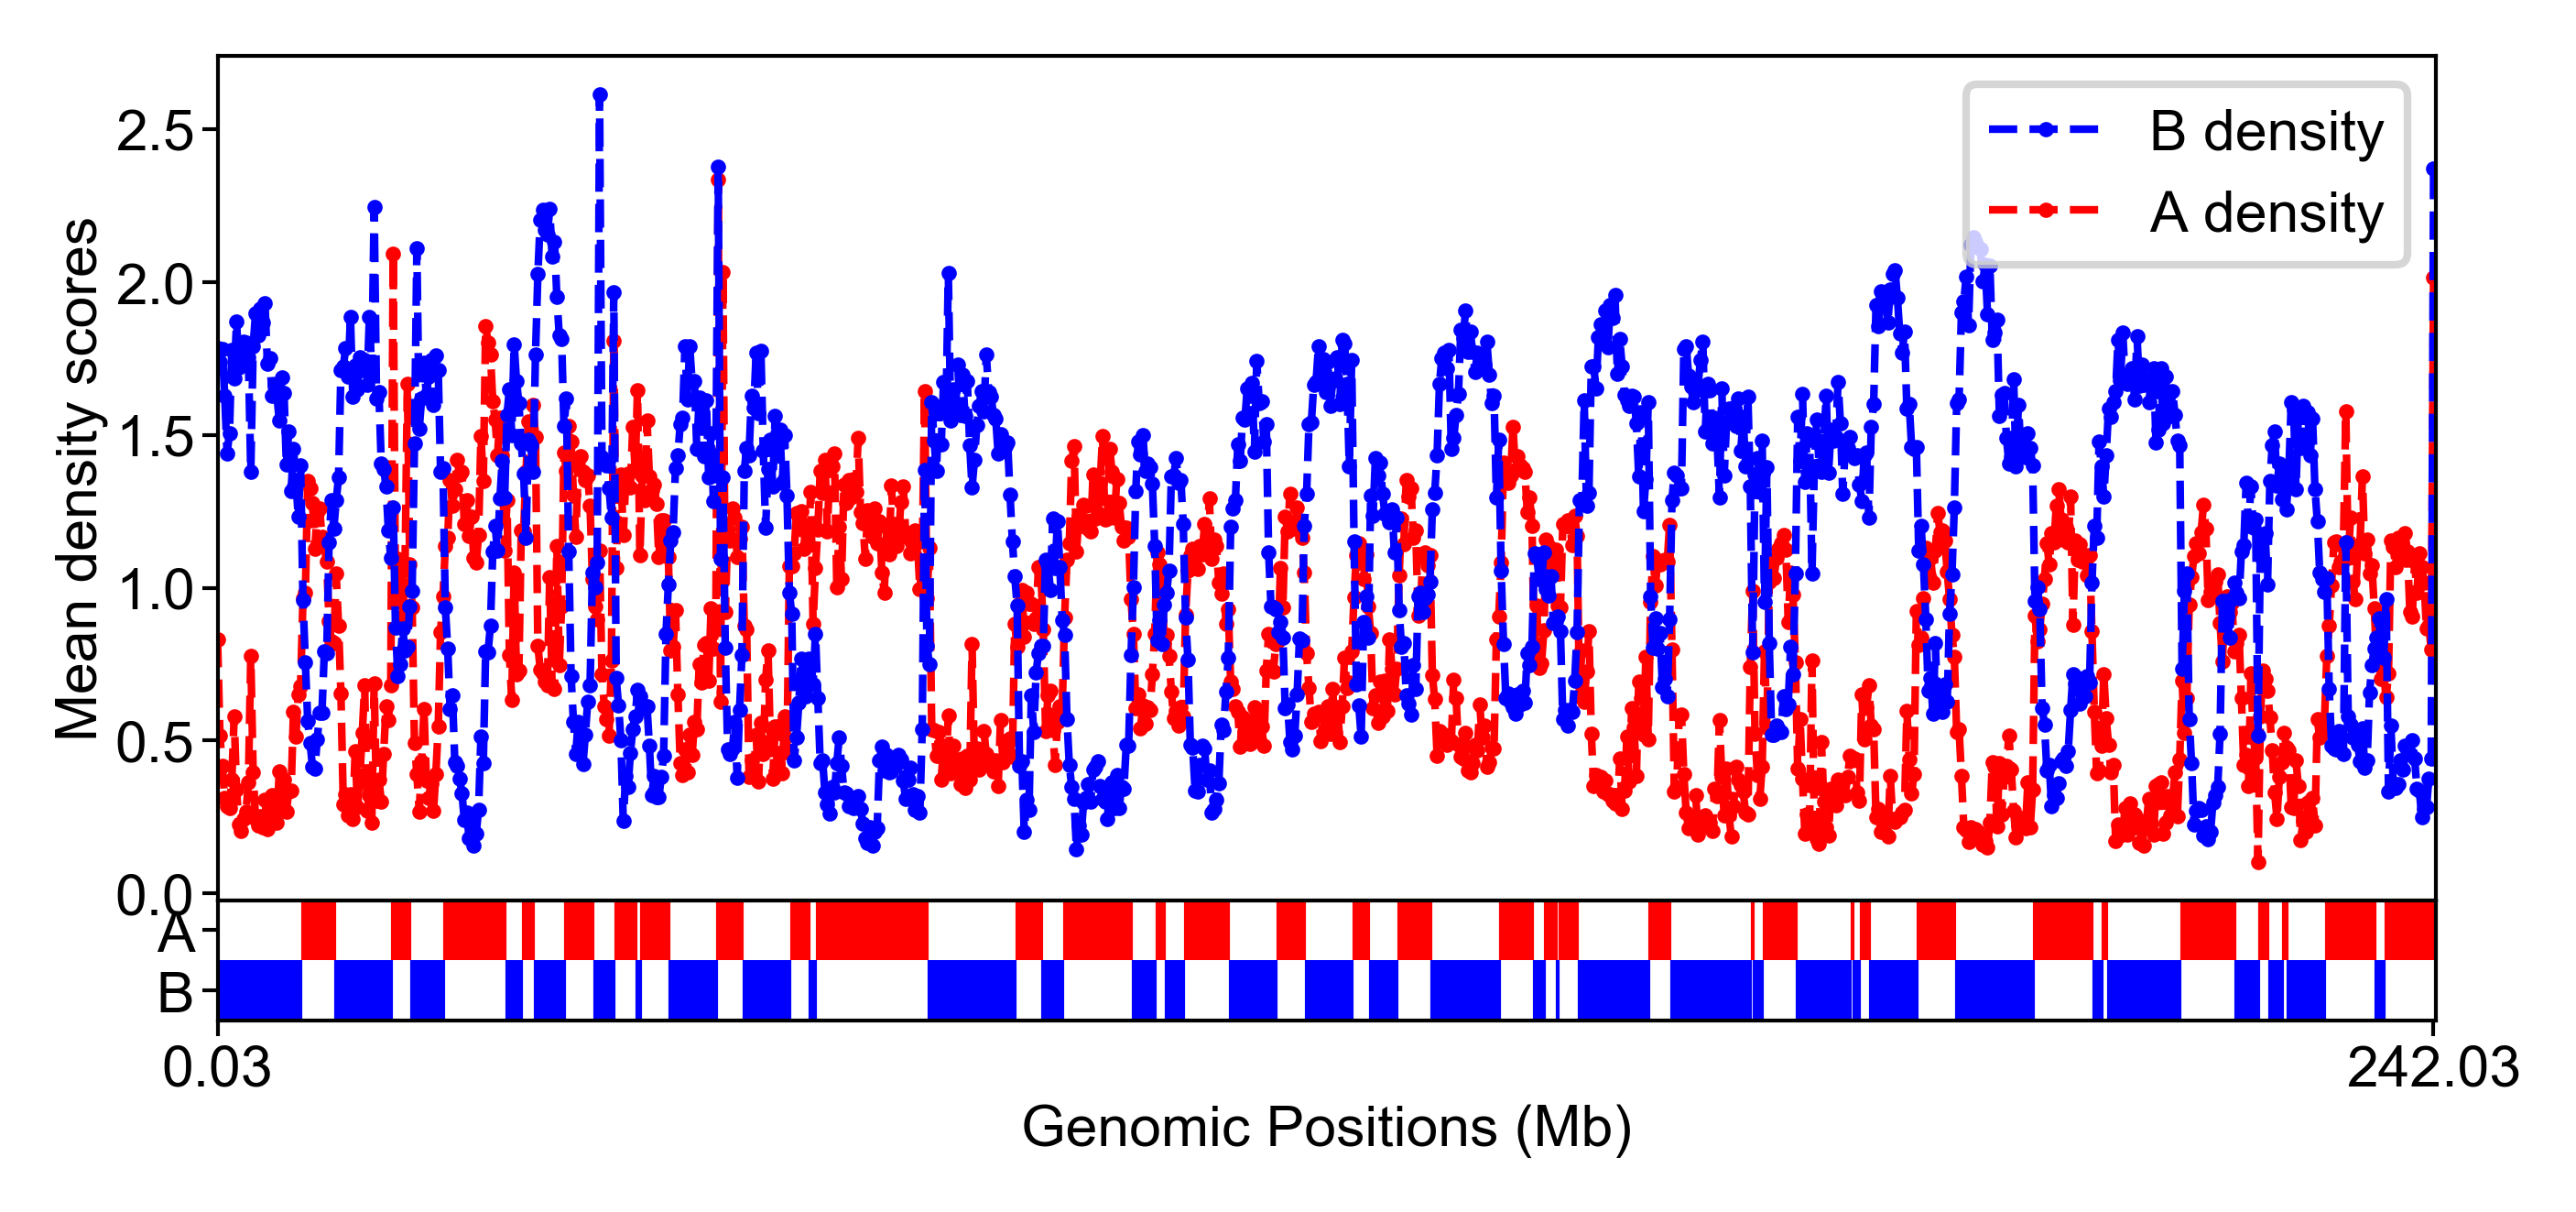

In [230]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['AB_dict']['A'], data_rep1['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=0.5,
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(genomic_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2G_chr2_mean_AB_density_rep1.pdf'), transparent=True)

plt.show()

## for only p-arm

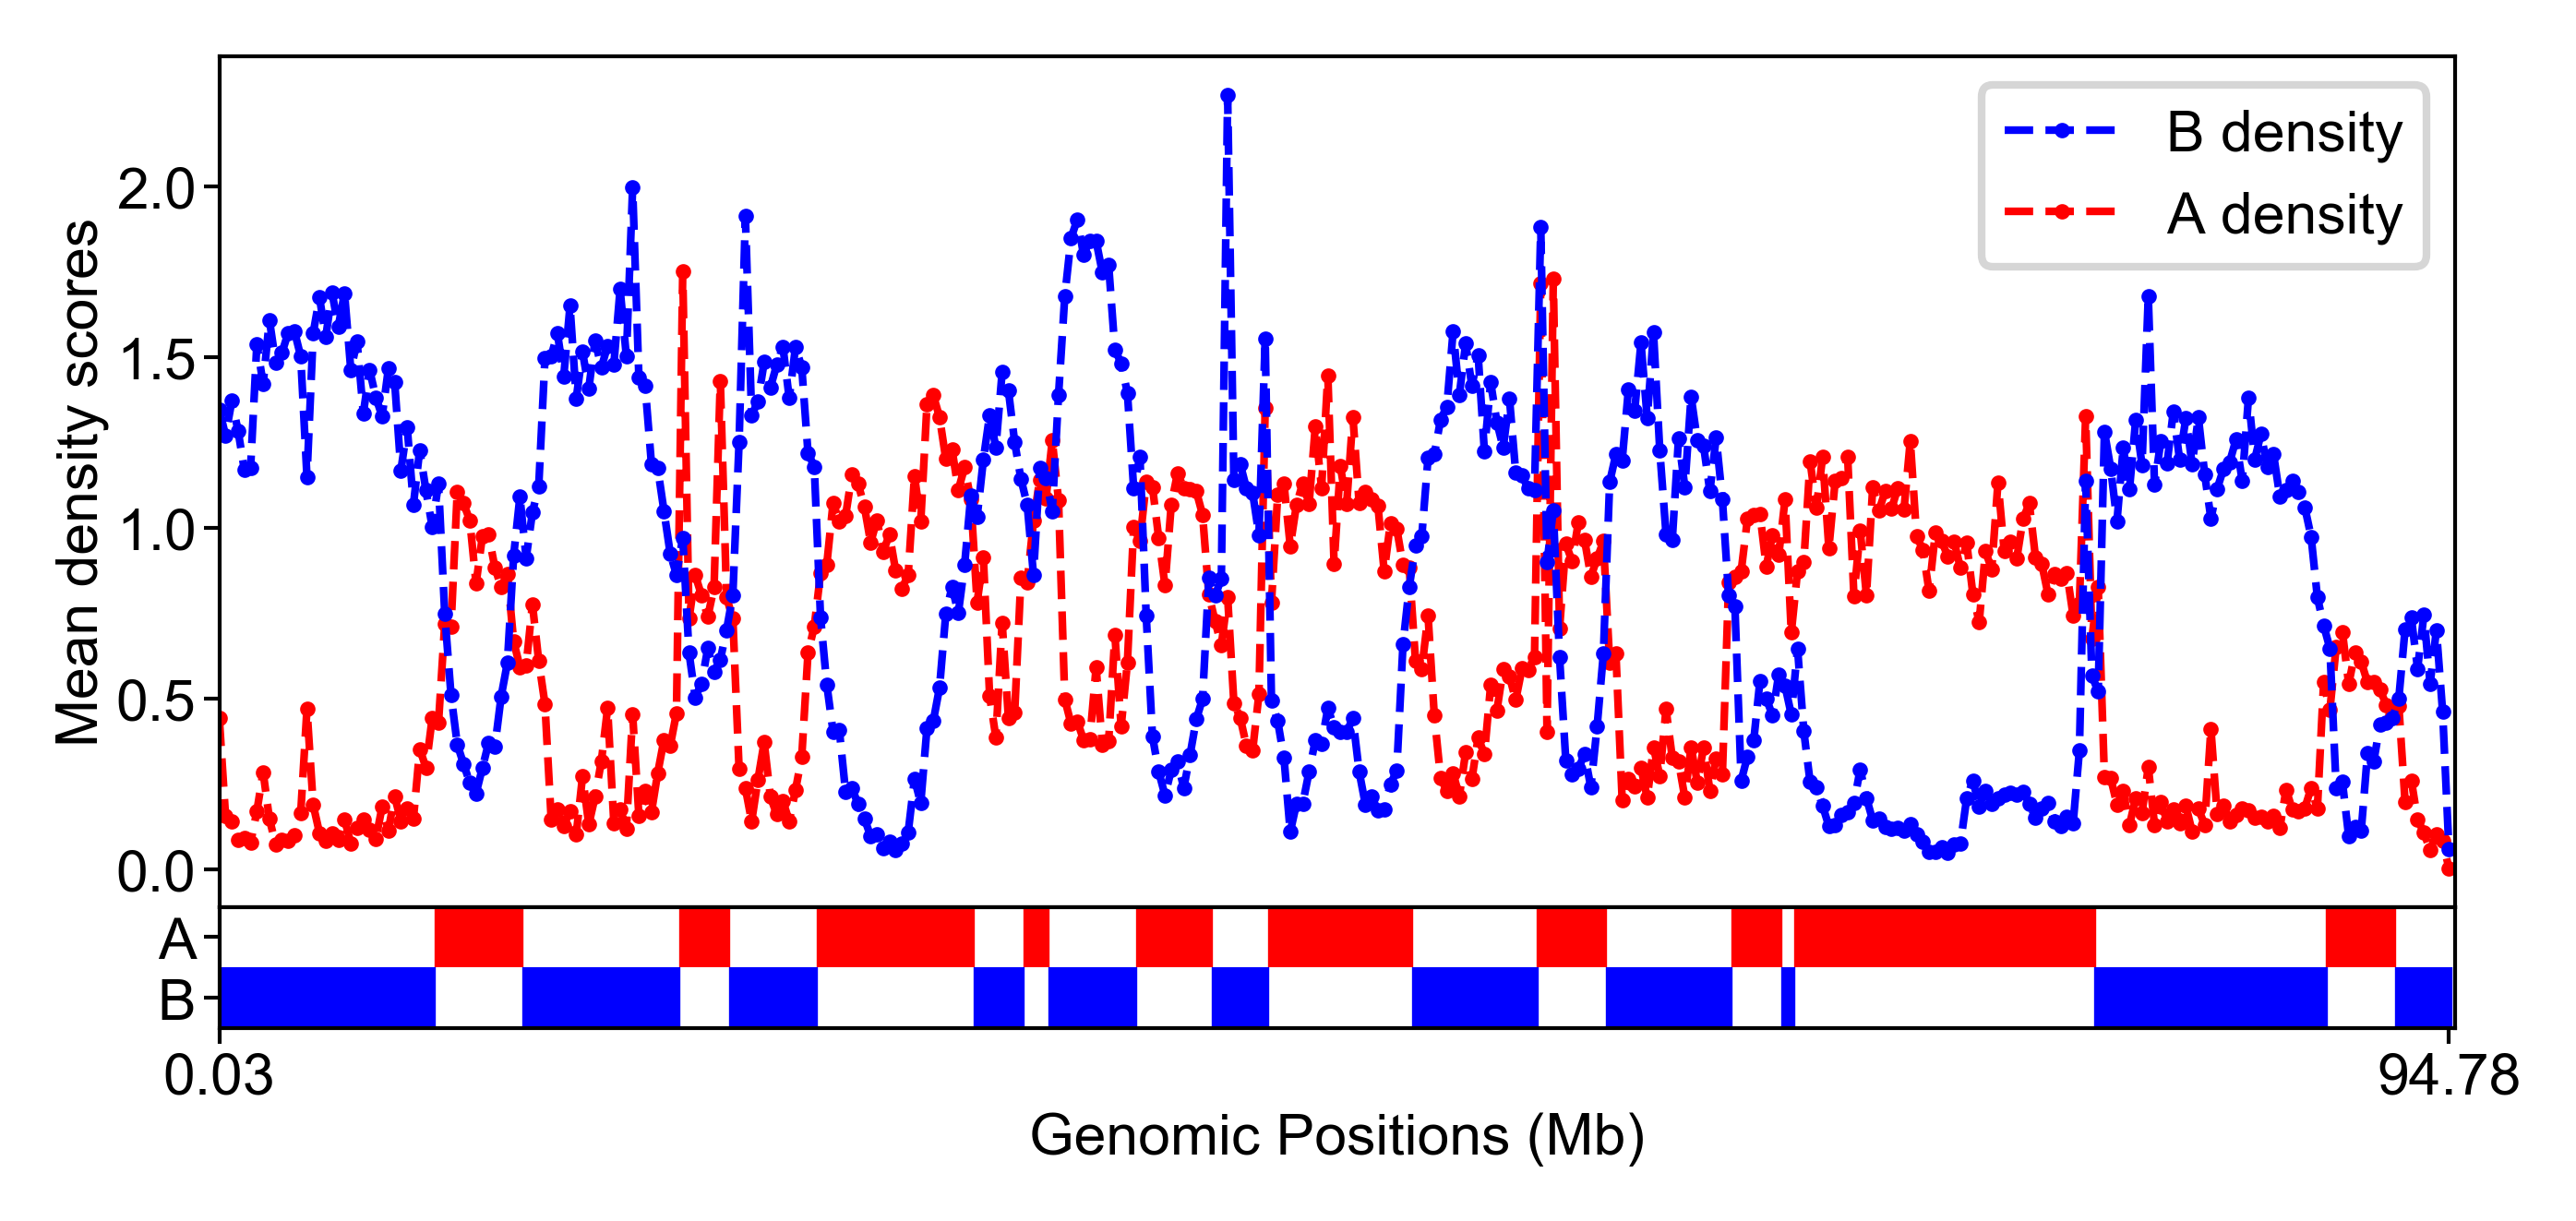

In [184]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['p_dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['p_dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['p_AB_dict']['A'], data_rep1['p_AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(genomic_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2G_chr2_p-arm_mean_AB_density_rep1.pdf'), transparent=True)

plt.show()

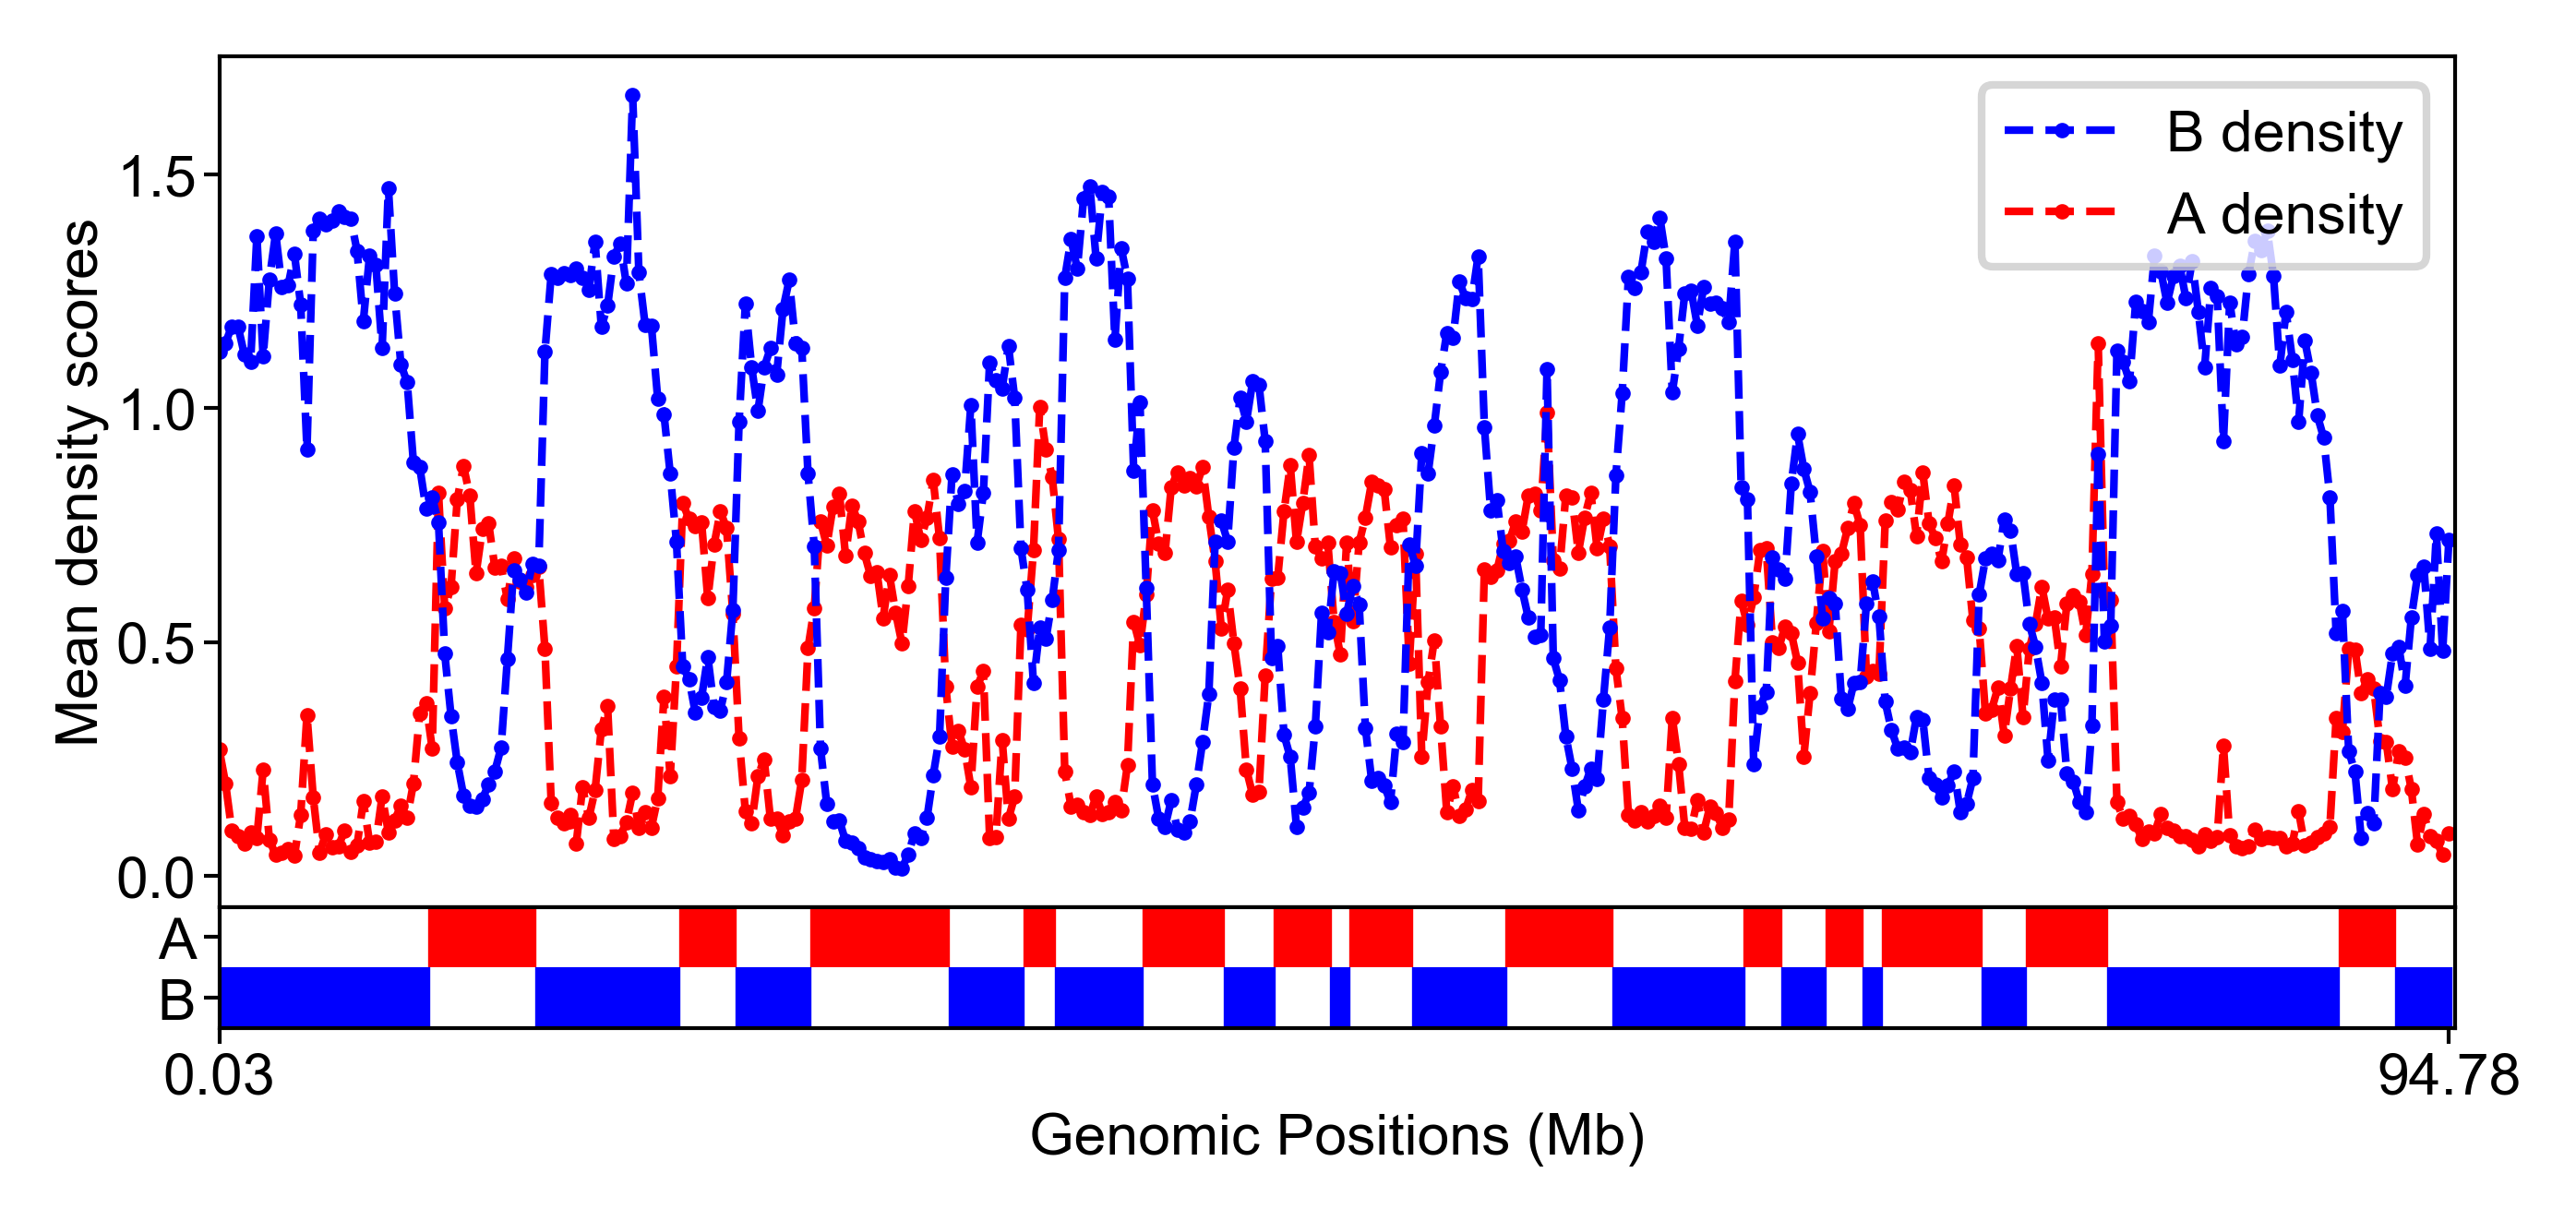

In [186]:
# Calculate mean A, B density
mean_A_scores = np.nanmedian([_s['A'] for _s in data_rep2['p_dna_density_scores']], axis=0)
mean_B_scores = np.nanmedian([_s['B'] for _s in data_rep2['p_dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(mean_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(mean_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Mean density scores", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(mean_A_scores))

comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep2['p_AB_dict']['A'], data_rep2['p_AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=1, 
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
_xticks = [0, len(mean_A_scores)-1]
comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(genomic_positions_Mb[_xticks])
comp_ax.set_xlabel(f'Genomic Positions (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2G_chr2_p-arm_mean_AB_density_rep2.pdf'), transparent=True)

plt.show()

## 0.4 segregation scores

In [202]:
def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores
from scipy.stats import scoreatpercentile

In [203]:
AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

  0%|                                                                                         | 0/3029 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
  0%|                                                                                         | 0/3029 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal
100%|█████████████████████████████████████████████████████████████████████████████| 3029/3029 [00:13<00:00, 227.60it/s]


## Fig 2F: segregation score histogram for Chr2

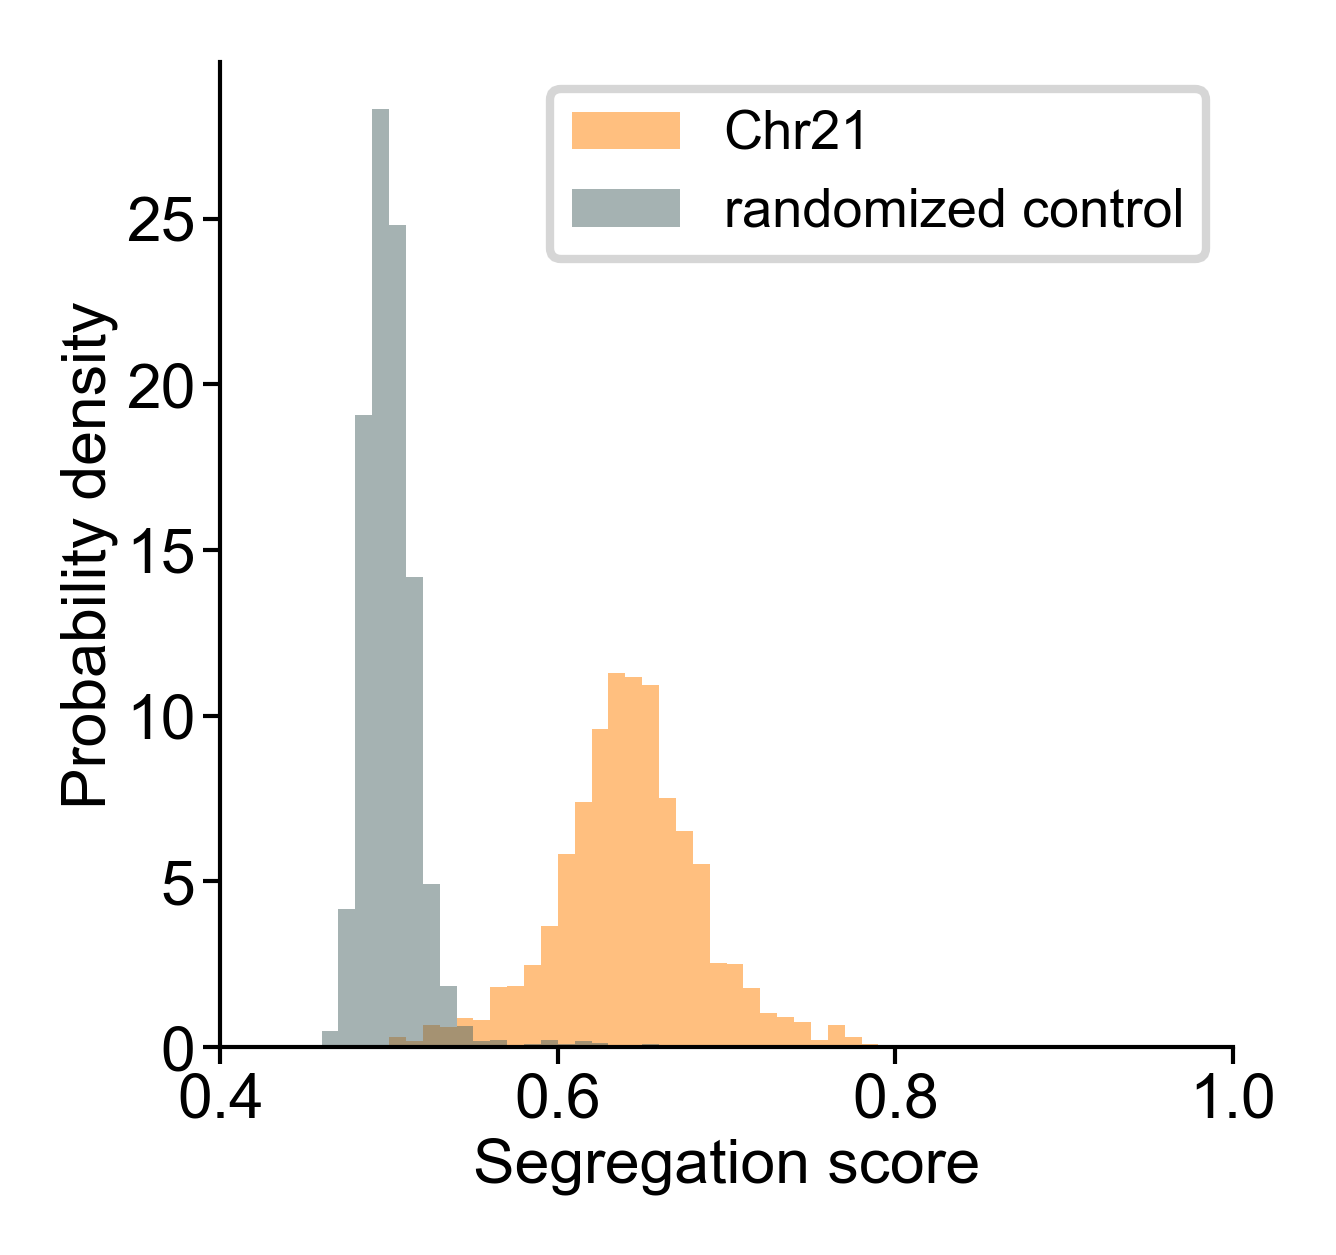

In [204]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep1['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2F_chr2_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

### For only P-arm, calculate segregation score and plot

In [205]:
p_crop = slice(0,357)

AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
AB_identities_rep1[data_rep1['p_AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['p_AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['p_dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['p_AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['p_AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['p_dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['p_AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['p_segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['p_randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

# Plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['p_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep1['p_randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("P-arm Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2F_chr2_p_arm_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

  0%|                                                                                         | 0/3029 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
  0%|                                                                                         | 0/3029 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
100%|█████████████████████████████████████████████████████████████████████████████| 3029/3029 [00:05<00:00, 579.16it/s]


  0%|                                                                                         | 0/4848 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
  0%|                                                                                         | 0/4848 [00:00<?, ?it/s]E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
100%|█████████████████████████████████████████████████████████████████████████████| 4848/4848 [00:08<00:00, 578.40it/s]


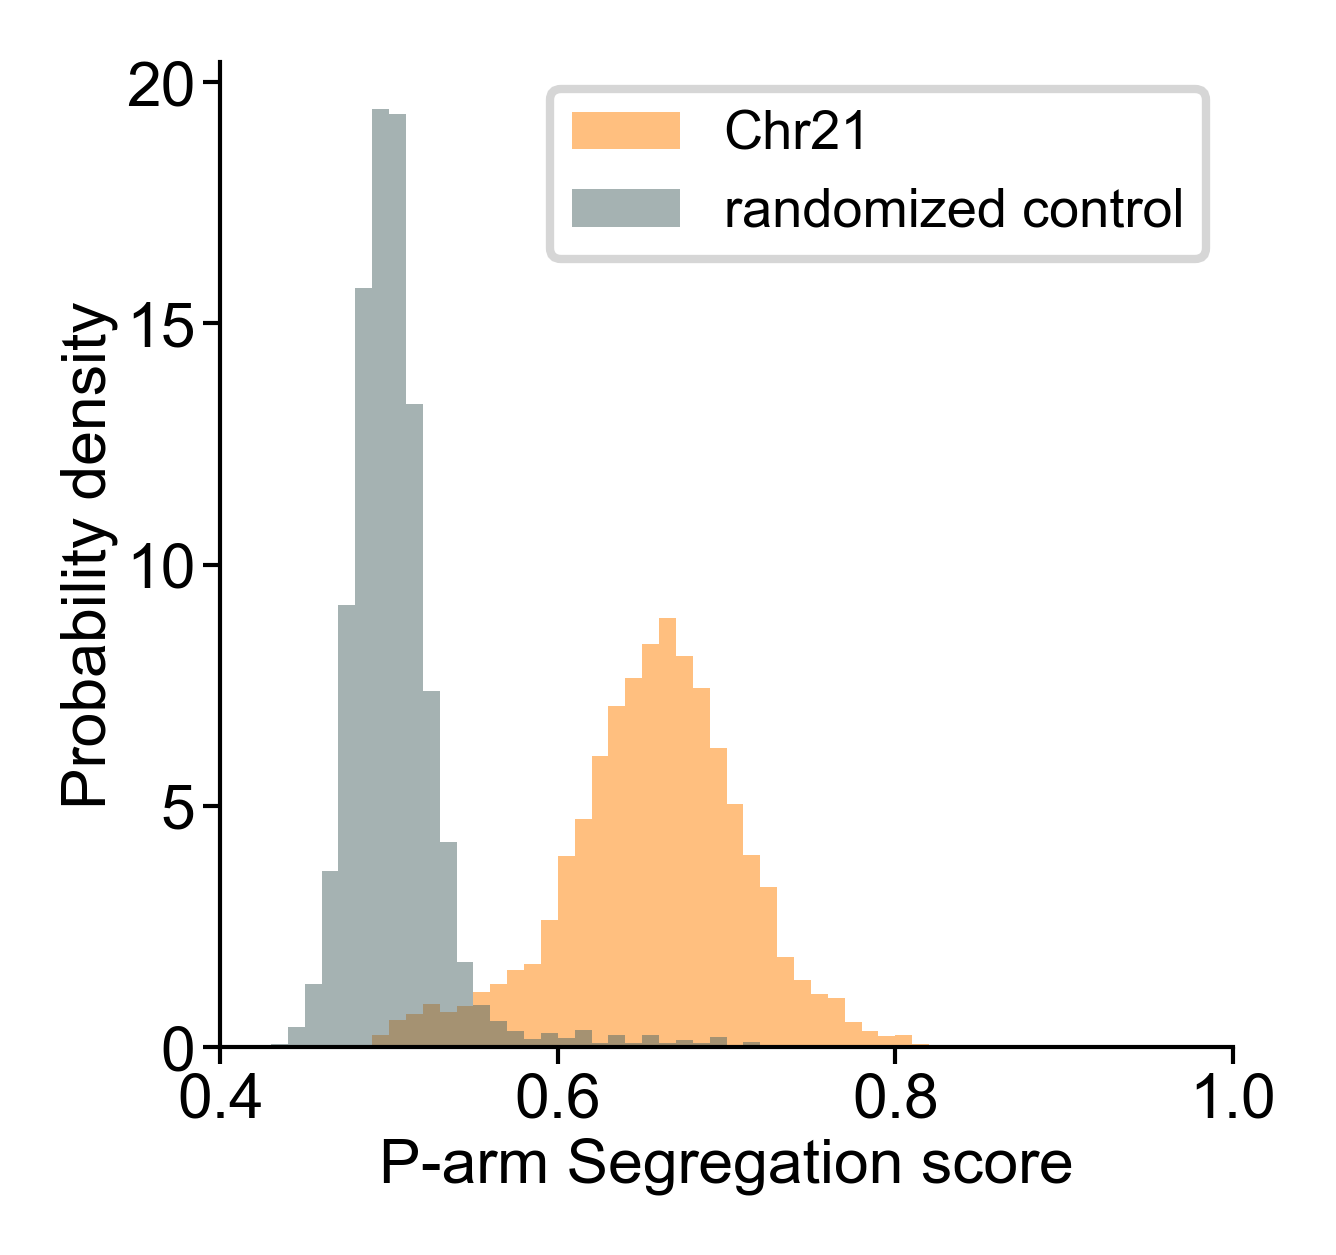

In [209]:
p_crop = slice(0,357)

AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0])) * np.nan
AB_identities_rep2[data_rep2['p_AB_dict']['A']] = 1
AB_identities_rep2[data_rep2['p_AB_dict']['B']] = 0

from tqdm import tqdm
# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep2['p_dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep2['p_AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep2['p_AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep2['p_dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep2['p_AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep2 vector for purity calculation
    _rand_AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0])) * np.nan
    _rand_AB_identities_rep2[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep2[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep2[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep2[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep2['p_segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep2['p_randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

# Plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep2['p_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr21')
ax.hist(data_rep2['p_randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("P-arm Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2F_chr2_p_arm_segregation_hist_rep2.pdf'), transparent=True)
plt.show()

# Domain contacts in the context of A/B compartments

## analyze only p-arm

In [110]:
# 1. get p-arm domains
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.85 
domain_dist_cutoff = 1000 # nm

p_crop = slice(0,357)

_domain_args = [(_hzxys[p_crop,1:], 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _hzxys in data_rep1['dna_hzxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'p_domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['p_domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    #data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    #data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 19.543s.


## Fig3C: purity of domains

In [170]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2

p_crop = slice(0,357)

AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0][p_crop])) * np.nan
AB_identities_rep1[data_rep1['p_AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['p_AB_dict']['B']] = 0

# calculate purity for p-arm
purity_p_rep1_list = []

for _dms in data_rep1['p_domain_starts']:
    
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    purity_p_rep1_list.append(np.array(_purities))

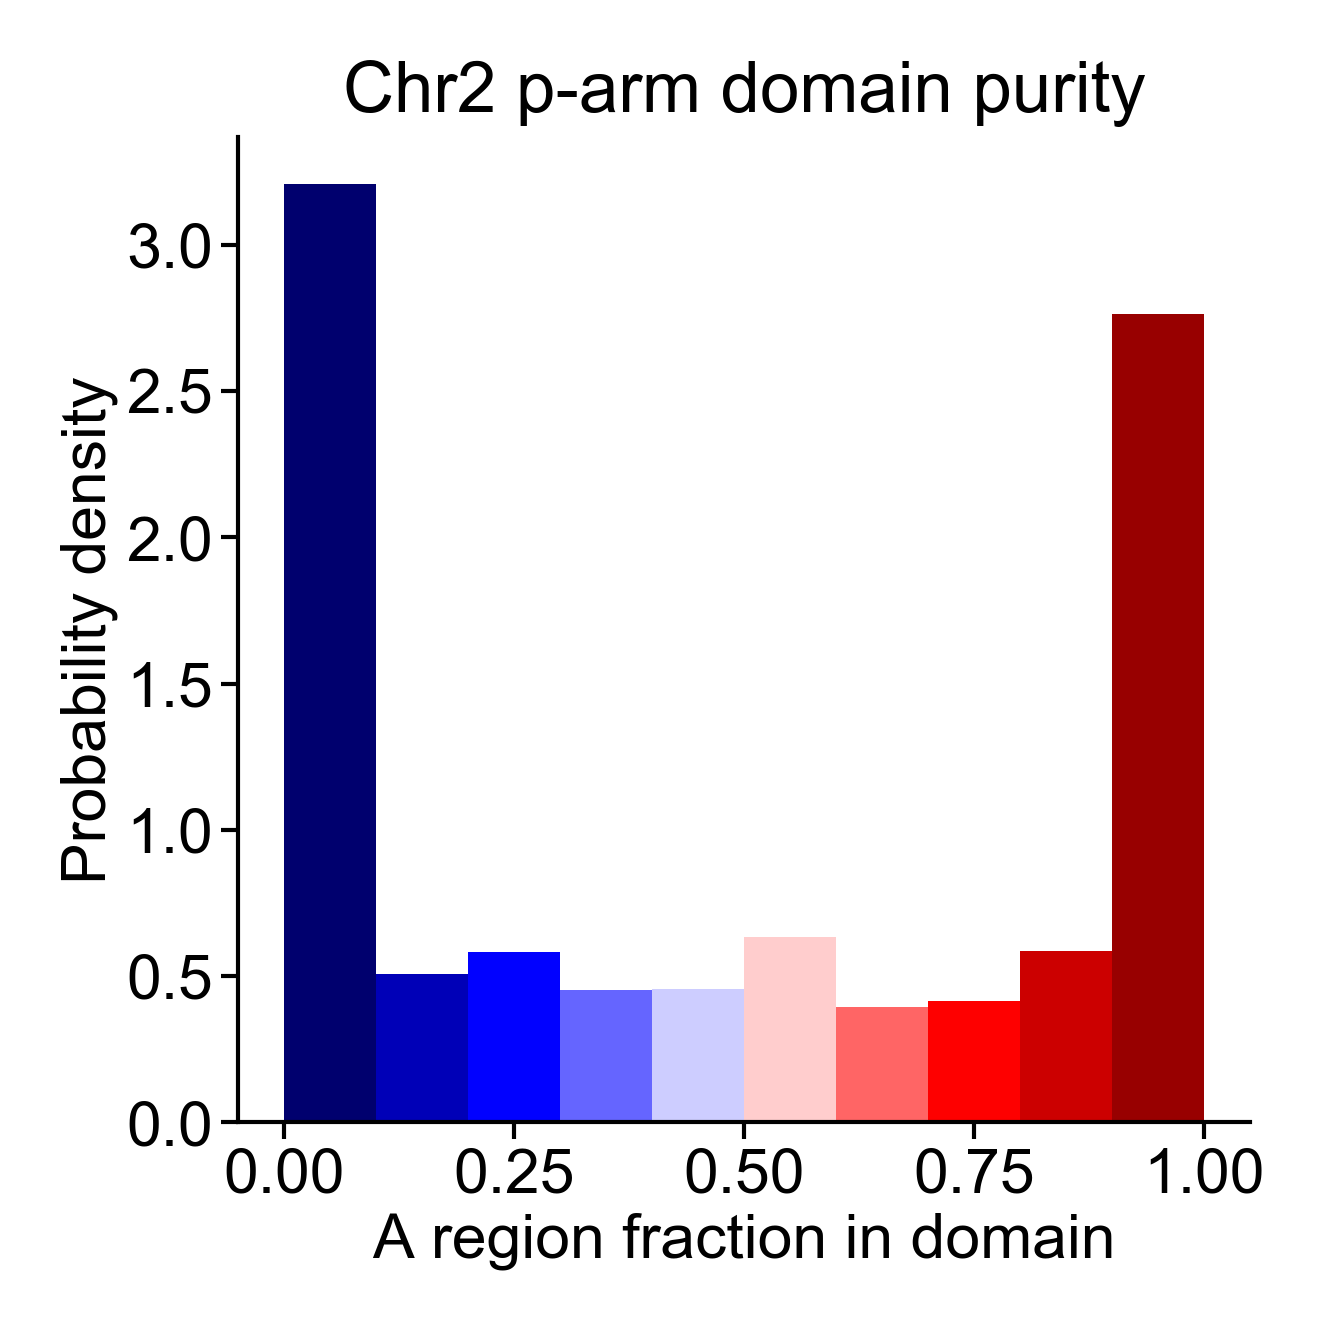

In [172]:
cmap = matplotlib.cm.seismic
bin_colors = cmap(_purity_bin_centers)
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

hist_alpha = 1

n, hbins, hpatches = ax.hist(np.concatenate(purity_p_rep1_list), bins=_purity_bins, 
                             alpha=hist_alpha, density=True, label='total')

for _color, _p in zip(bin_colors, hpatches):
    plt.setp(_p, 'facecolor', _color)

#hab = ax.hist(ama_AB, 24, range=(0,0.6), color='grey', alpha=hist_alpha, density=True, label='AB')
#hbb = ax.hist(ama_BB, 24, range=(0,0.6), color='b', alpha=hist_alpha, density=True, label='BB')

ax.set_xlabel("A region fraction in domain", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper right')
ax.set_title(f"Chr2 p-arm domain purity", pad=3, fontsize=_font_size+1)
    
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
# save
plt.savefig(os.path.join(figure_folder, 'Fig3C_histogram_purity_p_rep1.pdf'), transparent=True)
plt.show()

## call domain contacts

In [117]:
# cutoff for:
#  domain pairs touching each other -> insulation score <= 2
#  domain pairs fully intermix with each other -> insulation score <= 1
domain_interact_cutoff = 2
domain_intermix_cutoff = 1

p_crop = slice(0, 357)
#
cutoffs = [domain_intermix_cutoff,domain_interact_cutoff]

p_rep1_interdomain_list = [[] for cutoff in cutoffs]
for _hzxys, _domain_starts in tqdm(zip(data_rep1['dna_hzxys'], data_rep1['p_domain_starts'])):
    zxy = _hzxys[p_crop,1:]
    dom_starts_f = _domain_starts

    bad = np.isnan(zxy[:,0])
    zxy_ = zxy[~bad]
    mat=squareform(pdist(zxy_))
    dom_starts = np.zeros(len(zxy))
    dom_starts[dom_starts_f[:-1]]=1
    dom_starts = list(np.where(dom_starts[~bad])[0])+[len(zxy_)]
    fuses_all_v2_=[[] for cutoff in cutoffs]
    for i in range(len(dom_starts)-1):
        for j in range(i):
            in_i = squareform(mat[dom_starts[i]:dom_starts[i+1],dom_starts[i]:dom_starts[i+1]])
            in_j = squareform(mat[dom_starts[j]:dom_starts[j+1],dom_starts[j]:dom_starts[j+1]])
            in_doms = np.median(np.concatenate([in_i,in_j]))
            out_doms = np.median(mat[dom_starts[i]:dom_starts[i+1],dom_starts[j]:dom_starts[j+1]])
            ins_score = out_doms/in_doms
            for icutoff,cutoff in enumerate(cutoffs):
                if ins_score<cutoff:
                    fuses_all_v2_[icutoff].append([i,j])
    for icutoff,cutoff in enumerate(cutoffs):
        p_rep1_interdomain_list[icutoff].append(fuses_all_v2_[icutoff])


In [119]:
AB_identities_rep1 = np.ones(len(data_rep1['dna_hzxys'][0])) * np.nan
AB_identities_rep1[data_rep1['p_AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['p_AB_dict']['B']] = 0

from tqdm import tqdm_notebook as tqdm
# calculate purity and gdists between each pairs
p_rep1_purity_cutoff_list = []
p_rep1_gdist_cutoff_list = []

for _cutoff, _interdomain_list in zip(cutoffs, p_rep1_interdomain_list):
    print(f"insulation threshold: {_cutoff}")
    pair_purities = []
    pair_gdists = []
    pair_insulations = []
    pair_ids = []
    pair_sizes = []
    
    for _chrom_id, (_dms, _pairs) in tqdm(enumerate(zip(data_rep1['p_domain_starts'], _interdomain_list))):
        _dm_starts = _dms[:-1]
        _dm_ends = _dms[1:]
        _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
        # pairs called in interdomain
        for _p in _pairs:
            if _p[0] > _p[1]:
                _dm_gdist = genomic_dist_mat[int((_dm_starts[_p[0]]+_dm_ends[_p[0]])/2),
                                             int((_dm_starts[_p[1]]+_dm_ends[_p[1]])/2)]
                _dm_purites = np.array([_purities[_p[0]], _purities[_p[1]]])

                # append
                pair_purities.append(_dm_purites)
                pair_gdists.append(_dm_gdist)
                
    p_rep1_purity_cutoff_list.append(np.array(pair_purities))
    p_rep1_gdist_cutoff_list.append(np.array(pair_gdists))

    
# calculate purity and gdists between all domain candidate pairs, as the denominator
p_rep1_all_purity_pairs = []
p_rep1_all_gdists = []

for _chrom_id, _dms in tqdm(enumerate(data_rep1['p_domain_starts'])):
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    for _i, (_si, _ei) in enumerate(zip(_dm_starts, _dm_ends)):
        for _j, (_sj, _ej) in enumerate(zip(_dm_starts[:_i], _dm_ends[:_i])):
            _dm_gdist = genomic_dist_mat[int((_si+_ei)/2),
                                         int((_sj+_ej)/2)]
            _dm_purites = np.array([_purities[_i], _purities[_j]])
            # append
            p_rep1_all_purity_pairs.append(_dm_purites)
            p_rep1_all_gdists.append(_dm_gdist)
            
p_rep1_all_purity_pairs = np.array(p_rep1_all_purity_pairs)
p_rep1_all_gdists = np.array(p_rep1_all_gdists)

insulation threshold: 1


insulation threshold: 2


## Fig3E: domain interaction freqeuncy given purity

In [151]:
len(p_rep1_purity_cutoff_list[-1]) / len(p_rep1_all_purity_pairs)

0.4045463158595918

In [152]:
len(p_rep2_purity_cutoff_list[-1]) / len(p_rep2_all_purity_pairs)

0.37077949792864795

In [137]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


p_rep1_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = p_rep1_purity_cutoff_list[-1]
_gdist_list = p_rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
   #print(_p_ind)
    #if _gd <= gd_cutoff:
    p_rep1_purity_count_mat[_p_ind,_q_ind] += 1
    p_rep1_purity_count_mat[_q_ind,_p_ind] += 1
    
p_rep1_all_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(p_rep1_all_purity_pairs, p_rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    #print(_p_ind)
    #if _gd <= gd_cutoff:
    p_rep1_all_purity_count_mat[_p_ind,_q_ind] += 1
    p_rep1_all_purity_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
p_rep1_purity_prob_mat = p_rep1_purity_count_mat / p_rep1_all_purity_count_mat

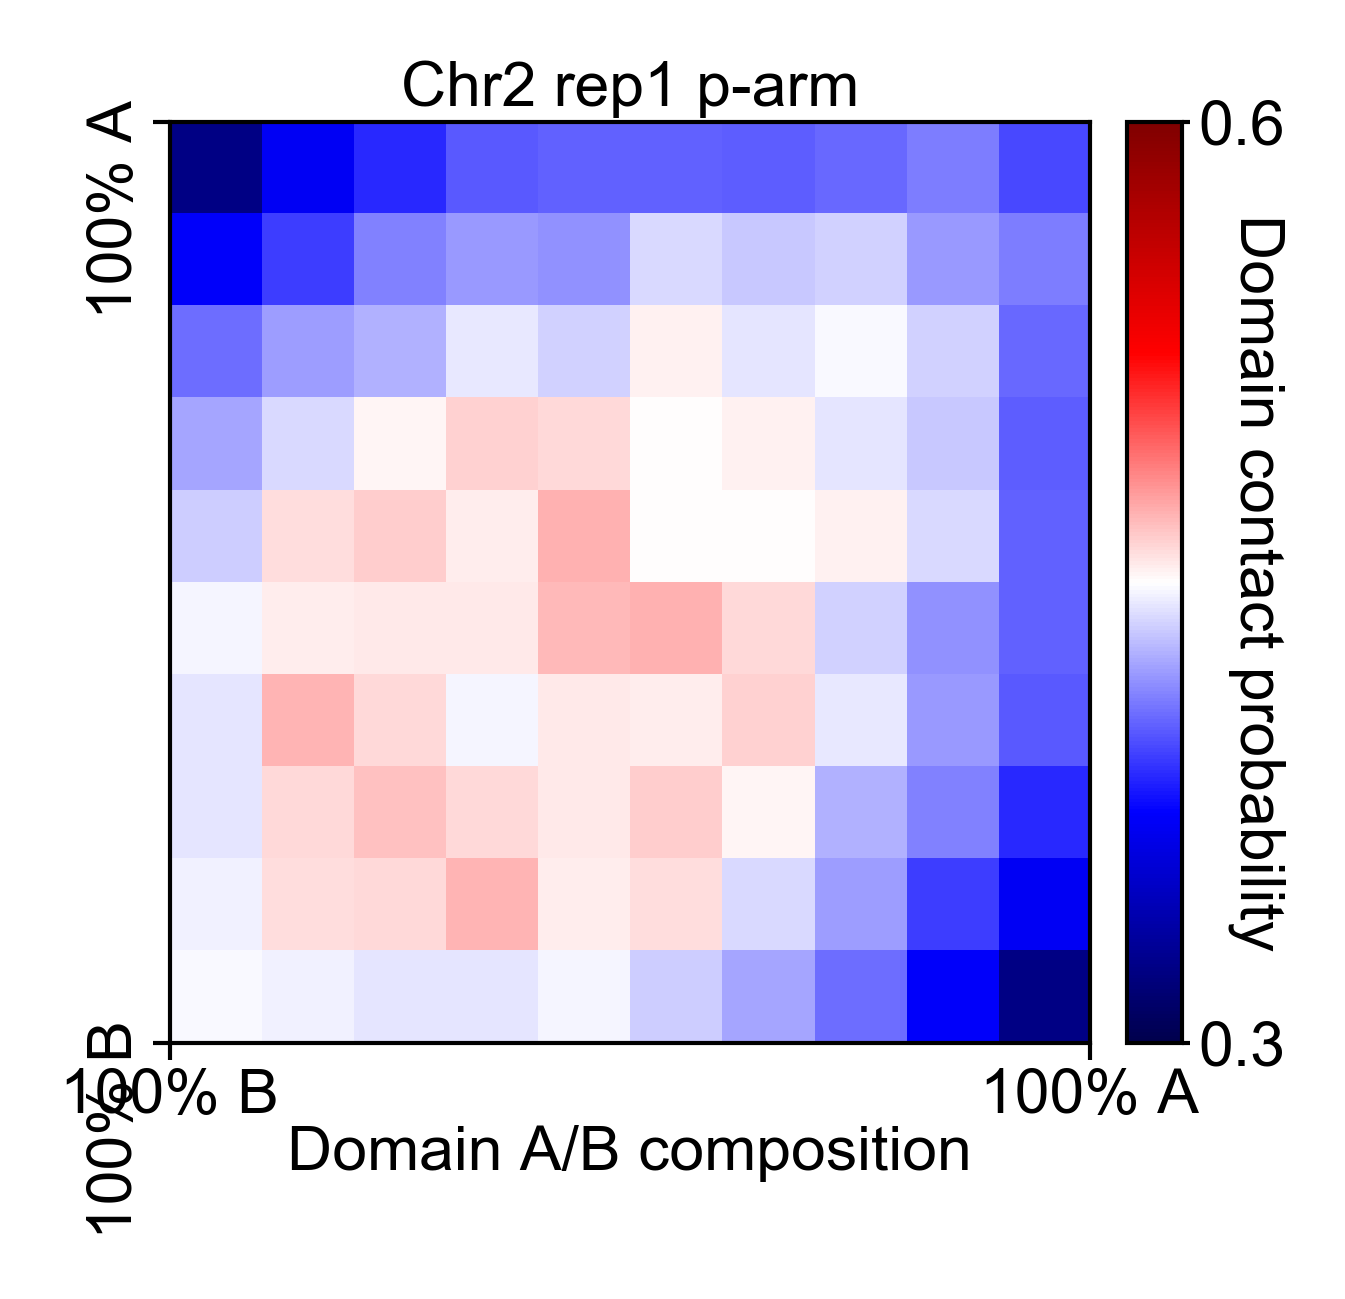

In [154]:
color_limits = [0.3, 0.6]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(p_rep1_purity_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1 p-arm", 
             fontsize=_font_size, pad=2)
# ticks
_xticks = [-0.5,9.5]
_xtick_labels = ['100% B', '100% A']

ax.set_ylim(_xticks)
ax.set_xlim(_xticks)

ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3E_chr2_contact_prob_given_purity_rep1.pdf'), transparent=True)

plt.show()

## Fig3F: domain contact probability given genomic distance

2


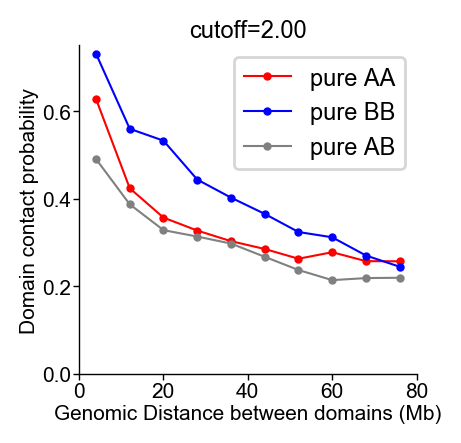

In [160]:
num_bins = 10
p_genomic_dist_mat = genomic_dist_mat[p_crop, p_crop]
_bins = np.linspace(np.min(p_genomic_dist_mat), 
                    #np.max(p_genomic_dist_mat), 
                    80,
                    num_bins+1)
_bin_centers = (_bins[:-1] + _bins[1:]) / 2
A_th = 0.9
B_th = 0.1

# Fig3F: cutoff = 2
_cutoff =  2
_index = cutoffs.index(_cutoff)
_gdists = p_rep1_gdist_cutoff_list[_index]
_purity_pairs = p_rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]<B_th)&(p_rep1_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]>A_th)&(p_rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]>A_th)&(p_rep1_all_purity_pairs[:,1]<B_th) \
                                    | (p_rep1_all_purity_pairs[:,0]<B_th)&(p_rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='pure AA')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='pure BB')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='pure AB')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.75])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3F_chr2_p-arm_insulation_genomic_{_cutoff:.2f}_rep1.pdf"), transparent=True)
plt.show()

## Fig3H: domain contact probability for intermixing domain pairs

1


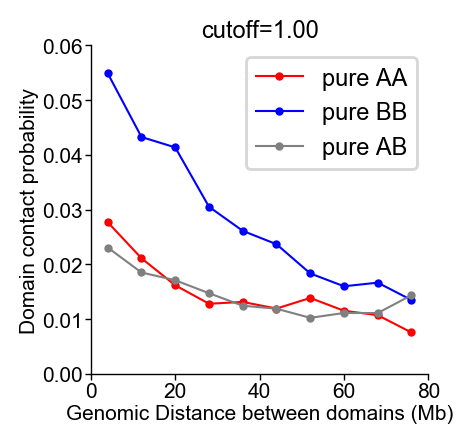

In [162]:
# Fig3H: cutoff = 1
_cutoff =  1
_index = cutoffs.index(_cutoff)
_gdists = p_rep1_gdist_cutoff_list[_index]
_purity_pairs = p_rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]<B_th)&(p_rep1_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]>A_th)&(p_rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(p_rep1_all_gdists[(p_rep1_all_purity_pairs[:,0]>A_th)&(p_rep1_all_purity_pairs[:,1]<B_th) \
                                    | (p_rep1_all_purity_pairs[:,0]<B_th)&(p_rep1_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='pure AA')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='pure BB')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='pure AB')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.06])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3H_chr2_p-arm_insulation_genomic_{_cutoff:.2f}_rep1.pdf"), transparent=True)
plt.show()

# rep2 only p-arm

In [111]:
sys.path.append(r"\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\BB_forPu")
import DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.85 
domain_dist_cutoff = 1000 # nm

p_crop = slice(0,357)

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep2['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'p_domain_starts' not in data_rep2:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep2['p_domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 23.660s.


## Fig3C: purity of domains

In [174]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2

p_crop = slice(0,357)

AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0][p_crop])) * np.nan
AB_identities_rep2[data_rep2['p_AB_dict']['A']] = 1
AB_identities_rep2[data_rep2['p_AB_dict']['B']] = 0

# calculate purity for p-arm
purity_p_rep2_list = []

for _dms in data_rep2['p_domain_starts']:
    
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep2[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    purity_p_rep2_list.append(np.array(_purities))

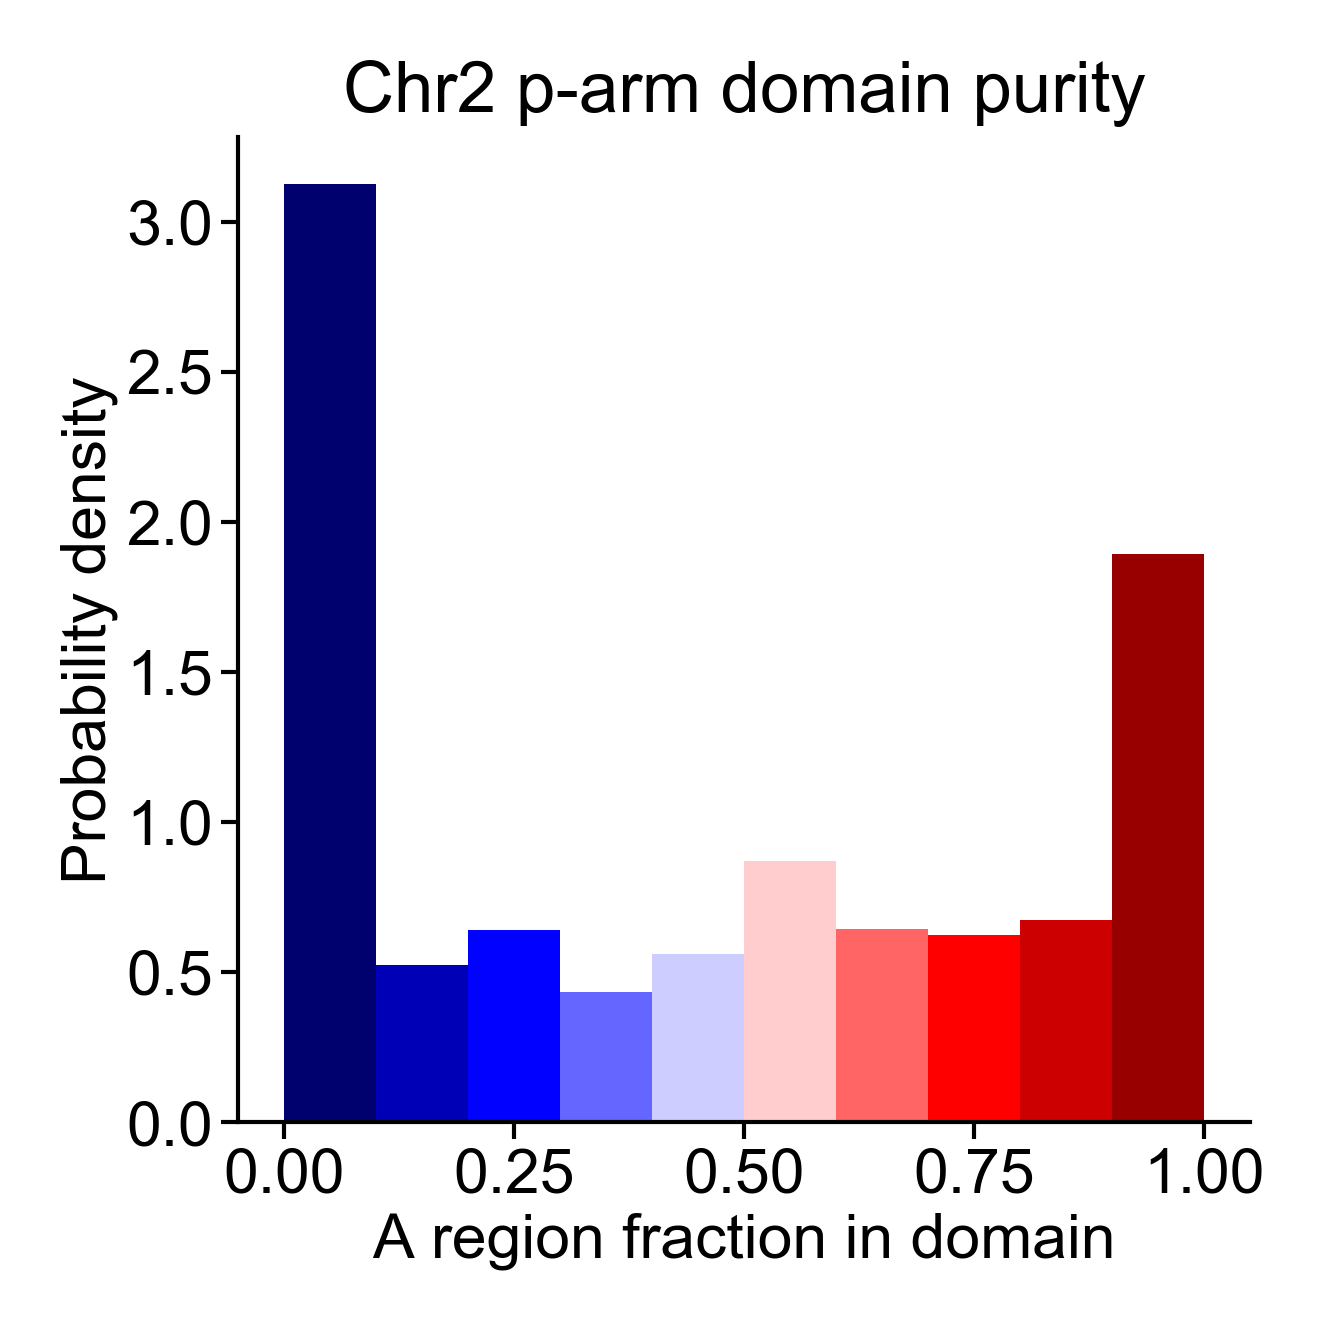

In [175]:
cmap = matplotlib.cm.seismic
bin_colors = cmap(_purity_bin_centers)
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

hist_alpha = 1

n, hbins, hpatches = ax.hist(np.concatenate(purity_p_rep2_list), bins=_purity_bins, 
                             alpha=hist_alpha, density=True, label='total')

for _color, _p in zip(bin_colors, hpatches):
    plt.setp(_p, 'facecolor', _color)

#hab = ax.hist(ama_AB, 24, range=(0,0.6), color='grey', alpha=hist_alpha, density=True, label='AB')
#hbb = ax.hist(ama_BB, 24, range=(0,0.6), color='b', alpha=hist_alpha, density=True, label='BB')

ax.set_xlabel("A region fraction in domain", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper right')
ax.set_title(f"Chr2 p-arm domain purity", pad=3, fontsize=_font_size+1)
    
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
# save
plt.savefig(os.path.join(figure_folder, 'Fig3C_histogram_purity_p_rep2.pdf'), transparent=True)
plt.show()

## call domain contacts

In [128]:
# cutoff for:
#  domain pairs touching each other -> insulation score <= 2
#  domain pairs fully intermix with each other -> insulation score <= 1
domain_interact_cutoff = 2
domain_intermix_cutoff = 1

p_crop = slice(0, 357)
#
cutoffs = [domain_intermix_cutoff,domain_interact_cutoff]

p_rep2_interdomain_list = [[] for cutoff in cutoffs]
for _zxys, _domain_starts in tqdm(zip(data_rep2['dna_zxys'], data_rep2['p_domain_starts'])):
    zxy = _zxys[p_crop]
    dom_starts_f = _domain_starts

    bad = np.isnan(zxy[:,0])
    zxy_ = zxy[~bad]
    mat=squareform(pdist(zxy_))
    dom_starts = np.zeros(len(zxy))
    dom_starts[dom_starts_f[:-1]]=1
    dom_starts = list(np.where(dom_starts[~bad])[0])+[len(zxy_)]
    fuses_all_v2_=[[] for cutoff in cutoffs]
    for i in range(len(dom_starts)-1):
        for j in range(i):
            in_i = squareform(mat[dom_starts[i]:dom_starts[i+1],dom_starts[i]:dom_starts[i+1]])
            in_j = squareform(mat[dom_starts[j]:dom_starts[j+1],dom_starts[j]:dom_starts[j+1]])
            in_doms = np.median(np.concatenate([in_i,in_j]))
            out_doms = np.median(mat[dom_starts[i]:dom_starts[i+1],dom_starts[j]:dom_starts[j+1]])
            ins_score = out_doms/in_doms
            for icutoff,cutoff in enumerate(cutoffs):
                if ins_score<cutoff:
                    fuses_all_v2_[icutoff].append([i,j])
    for icutoff,cutoff in enumerate(cutoffs):
        p_rep2_interdomain_list[icutoff].append(fuses_all_v2_[icutoff])


In [147]:
AB_identities_rep2 = np.ones(len(data_rep2['dna_zxys'][0])) * np.nan
AB_identities_rep2[data_rep2['p_AB_dict']['A']] = 1
AB_identities_rep2[data_rep2['p_AB_dict']['B']] = 0

from tqdm import tqdm_notebook as tqdm
# calculate purity and gdists between each pairs
p_rep2_purity_cutoff_list = []
p_rep2_gdist_cutoff_list = []

for _cutoff, _interdomain_list in zip(cutoffs, p_rep2_interdomain_list):
    print(f"insulation threshold: {_cutoff}")
    pair_purities = []
    pair_gdists = []
    pair_insulations = []
    pair_ids = []
    pair_sizes = []
    
    for _chrom_id, (_dms, _pairs) in tqdm(enumerate(zip(data_rep2['p_domain_starts'], _interdomain_list))):
        _dm_starts = _dms[:-1]
        _dm_ends = _dms[1:]
        _purities = [np.mean(AB_identities_rep2[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
        # pairs called in interdomain
        for _p in _pairs:
            if _p[0] > _p[1]:
                _dm_gdist = genomic_dist_mat[int((_dm_starts[_p[0]]+_dm_ends[_p[0]])/2),
                                             int((_dm_starts[_p[1]]+_dm_ends[_p[1]])/2)]
                _dm_purites = np.array([_purities[_p[0]], _purities[_p[1]]])

                # append
                pair_purities.append(_dm_purites)
                pair_gdists.append(_dm_gdist)
                
    p_rep2_purity_cutoff_list.append(np.array(pair_purities))
    p_rep2_gdist_cutoff_list.append(np.array(pair_gdists))

    
# calculate purity and gdists between all domain candidate pairs, as the denominator
p_rep2_all_purity_pairs = []
p_rep2_all_gdists = []

for _chrom_id, _dms in tqdm(enumerate(data_rep2['p_domain_starts'])):
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep2[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    for _i, (_si, _ei) in enumerate(zip(_dm_starts, _dm_ends)):
        for _j, (_sj, _ej) in enumerate(zip(_dm_starts[:_i], _dm_ends[:_i])):
            _dm_gdist = genomic_dist_mat[int((_si+_ei)/2),
                                         int((_sj+_ej)/2)]
            _dm_purites = np.array([_purities[_i], _purities[_j]])
            # append
            p_rep2_all_purity_pairs.append(_dm_purites)
            p_rep2_all_gdists.append(_dm_gdist)
            
p_rep2_all_purity_pairs = np.array(p_rep2_all_purity_pairs)
p_rep2_all_gdists = np.array(p_rep2_all_gdists)

insulation threshold: 1


insulation threshold: 2


## Fig3E: domain interaction freqeuncy given purity

In [142]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


p_rep2_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = p_rep2_purity_cutoff_list[-1]
_gdist_list = p_rep2_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
   #print(_p_ind)
    #if _gd <= gd_cutoff:
    p_rep2_purity_count_mat[_p_ind,_q_ind] += 1
    p_rep2_purity_count_mat[_q_ind,_p_ind] += 1
    
p_rep2_all_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(p_rep2_all_purity_pairs, p_rep2_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p <= _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q <= _purity_bins[1:]))[0][0]
    #print(_p_ind)
    #if _gd <= gd_cutoff:
    p_rep2_all_purity_count_mat[_p_ind,_q_ind] += 1
    p_rep2_all_purity_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
p_rep2_purity_prob_mat = p_rep2_purity_count_mat / p_rep2_all_purity_count_mat

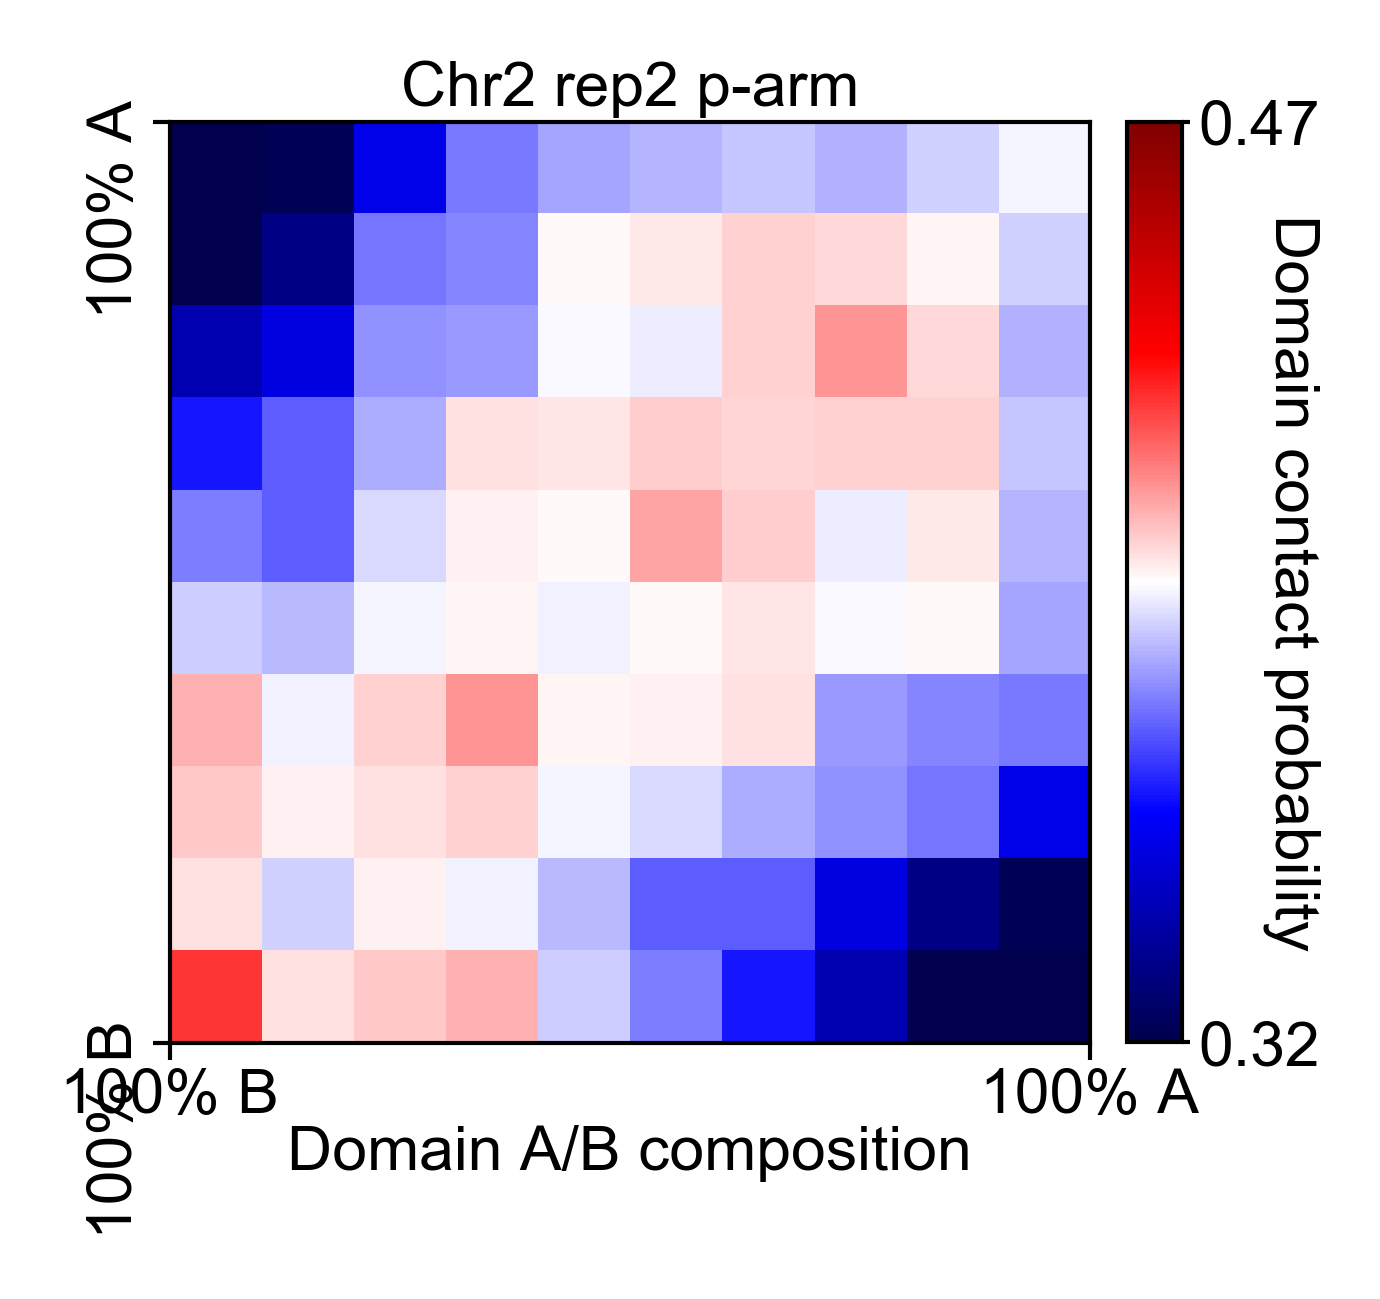

In [157]:
color_limits = [0.32, 0.47]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(p_rep2_purity_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep2 p-arm", 
             fontsize=_font_size, pad=2)
# ticks
_xticks = [-0.5,9.5]
_xtick_labels = ['100% B', '100% A']

ax.set_ylim(_xticks)
ax.set_xlim(_xticks)

ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3E_chr2_contact_prob_given_purity_rep2.pdf'), transparent=True)

plt.show()

In [234]:
p_rep1_purity_prob_mat[0,0],p_rep1_purity_prob_mat[-1,-1]

(0.448185360612105, 0.3962771514485315)

In [232]:
p_rep2_purity_prob_mat[0,0],p_rep2_purity_prob_mat[-1,-1]

(0.42466925204356015, 0.3936990973157964)

## Fig3F: domain contact probability given genomic distance

2


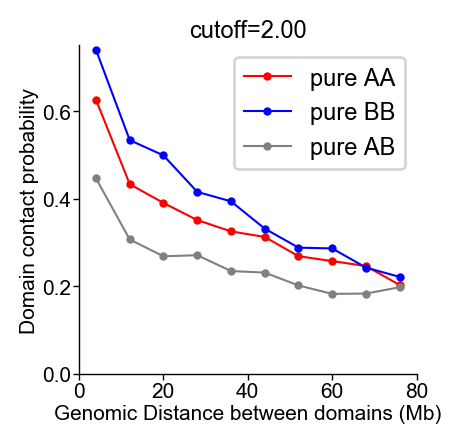

In [163]:
num_bins = 10
p_genomic_dist_mat = genomic_dist_mat[p_crop, p_crop]
_bins = np.linspace(np.min(p_genomic_dist_mat), 
                    #np.max(p_genomic_dist_mat), 
                    80,
                    num_bins+1)
_bin_centers = (_bins[:-1] + _bins[1:]) / 2
A_th = 0.9
B_th = 0.1

# Fig3F: cutoff = 2
_cutoff =  2
_index = cutoffs.index(_cutoff)
_gdists = p_rep2_gdist_cutoff_list[_index]
_purity_pairs = p_rep2_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]<B_th)&(p_rep2_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]>A_th)&(p_rep2_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]>A_th)&(p_rep2_all_purity_pairs[:,1]<B_th) \
                                    | (p_rep2_all_purity_pairs[:,0]<B_th)&(p_rep2_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='pure AA')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='pure BB')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='pure AB')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.75])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3F_chr2_p-arm_insulation_genomic_{_cutoff:.2f}_rep2.pdf"), transparent=True)
plt.show()

## Fig3H: domain contact probability for intermixing domain pairs

1


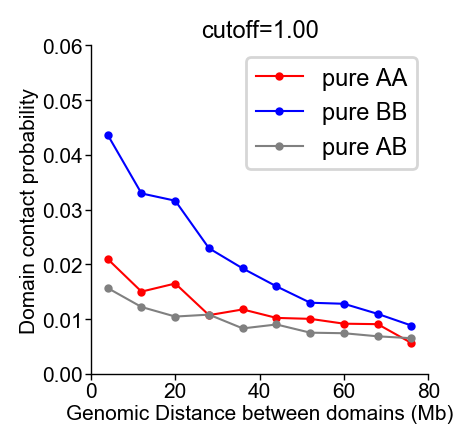

In [164]:
# Fig3H: cutoff = 1
_cutoff =  1
_index = cutoffs.index(_cutoff)
_gdists = p_rep2_gdist_cutoff_list[_index]
_purity_pairs = p_rep2_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]>A_th)],bins=_bins)
nBB_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]<B_th)&(p_rep2_all_purity_pairs[:,1]<B_th)],bins=_bins)
nAA_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]>A_th)&(p_rep2_all_purity_pairs[:,1]>A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0]<B_th)&(_purity_pairs[:,1]>A_th) \
                             | (_purity_pairs[:,0]>A_th)&(_purity_pairs[:,1]<B_th)],bins=_bins)
nAB_all,_ = np.histogram(p_rep2_all_gdists[(p_rep2_all_purity_pairs[:,0]>A_th)&(p_rep2_all_purity_pairs[:,1]<B_th) \
                                    | (p_rep2_all_purity_pairs[:,0]<B_th)&(p_rep2_all_purity_pairs[:,1]>A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='pure AA')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='pure BB')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='pure AB')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.06])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3H_chr2_p-arm_insulation_genomic_{_cutoff:.2f}_rep2.pdf"), transparent=True)
plt.show()